# 변동성 돌파 + ADX/Chaikin + 절대모멘텀 + 변동성 필터 전략

기존 ADX/Chaikin 전략에 추가 필터를 적용하여 거래 빈도를 대폭 감소
- 기존: 변동성 돌파 + (ADX 강세 OR Chaikin 강세)
- 추가: 절대 모멘텀 필터 (20일 수익률 > 0)
- 추가: 변동성 필터 (ATR 상승 또는 Range 확대)

## 1. 필요한 라이브러리 임포트 및 환경 설정

In [2]:
import pandas as pd
import numpy as np
from google.cloud import bigquery
from google.oauth2 import service_account
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# matplotlib 한글 설정
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

## 2. BigQuery 연결 및 ADX/Chaikin 포함 데이터 로드 함수

In [3]:
# BigQuery 클라이언트 초기화
def get_bigquery_client():
    service_account_path = "/Users/cg01-piwoo/my_quant/access_info/data/quantsungyong-663604552de9.json"
    credentials = service_account.Credentials.from_service_account_file(
        service_account_path,
        scopes=["https://www.googleapis.com/auth/cloud-platform"]
    )
    return bigquery.Client(credentials=credentials, project=credentials.project_id)

client = get_bigquery_client()


# ADX와 Chaikin 지표를 포함한 데이터 로드 함수
def get_stock_data_with_indicators(ticker, start_date=None, end_date=None):
    date_conditions = []
    if start_date:
        date_conditions.append(f"JSON_EXTRACT_SCALAR(r.dates_array[OFFSET(i.pos)], '$') >= '{start_date}'")
    if end_date:
        date_conditions.append(f"JSON_EXTRACT_SCALAR(r.dates_array[OFFSET(i.pos)], '$') <= '{end_date}'")
    
    date_filter = f"AND {' AND '.join(date_conditions)}" if date_conditions else ""
    
    query = f"""
    WITH raw_data AS (
      SELECT 
        ticker,
        -- 가격 데이터
        JSON_EXTRACT_ARRAY(data, '$.dates') AS dates_array,
        JSON_EXTRACT_ARRAY(data, '$.open') AS open_array,
        JSON_EXTRACT_ARRAY(data, '$.high') AS high_array,
        JSON_EXTRACT_ARRAY(data, '$.low') AS low_array,
        JSON_EXTRACT_ARRAY(data, '$.close') AS close_array,
        JSON_EXTRACT_ARRAY(data, '$.volume') AS volume_array,
        
        -- ADX 관련 지표
        JSON_EXTRACT_ARRAY(data, '$.adx_14_values') AS adx_14_values_array,
        JSON_EXTRACT_ARRAY(data, '$.pdi_14_values') AS pdi_14_values_array,
        JSON_EXTRACT_ARRAY(data, '$.mdi_14_values') AS mdi_14_values_array,
        
        -- Chaikin Oscillator 관련 지표 (수정된 필드명)
        JSON_EXTRACT_ARRAY(data, '$.chaikin_oscillator') AS chaikin_oscillator_array,
        JSON_EXTRACT_ARRAY(data, '$.chaikin_9_signal_line') AS chaikin_signal_array,

        -- MACD 관련
        JSON_EXTRACT_ARRAY(data, '$.macd_line') AS macd_line_array,
        JSON_EXTRACT_ARRAY(data, '$.macd_9_signal_line') AS macd_9_signal_line_array,
        JSON_EXTRACT_ARRAY(data, '$.macd_histogram') AS macd_histogram_array,
        JSON_EXTRACT_ARRAY(data, '$.macd_signals') AS macd_signals_array,
        
        -- Stochastic
        JSON_EXTRACT_ARRAY(data, '$.stochastic_k_line') AS stochastic_k_line_array,
        JSON_EXTRACT_ARRAY(data, '$.stochastic_d_line') AS stochastic_d_line_array,
        
        -- OBV 관련
        JSON_EXTRACT_ARRAY(data, '$.obv_values') AS obv_values_array,
        JSON_EXTRACT_ARRAY(data, '$.obv_9_ma') AS obv_9_ma_array,
        JSON_EXTRACT_ARRAY(data, '$.obv_signals') AS obv_signals_array,

        -- RSI 관련
        JSON_EXTRACT_ARRAY(data, '$.rsi_14_values') AS rsi_14_values_array,
        JSON_EXTRACT_ARRAY(data, '$.rsi_9_signal_line') AS rsi_9_signal_line_array,
        JSON_EXTRACT_ARRAY(data, '$.rsi_histogram') AS rsi_histogram_array,
        JSON_EXTRACT_ARRAY(data, '$.rsi_signals') AS rsi_signals_array,
              
        -- ATR 관련 지표
        JSON_EXTRACT_ARRAY(data, '$.atr') AS atr_array,

        -- 배열 길이
        ARRAY_LENGTH(JSON_EXTRACT_ARRAY(data, '$.close')) AS array_length
        
      FROM 
        `quantsungyong.finviz_data.stock_data_with_indicators`
      WHERE 
        ticker = '{ticker}'
    ),
    indices AS (
      SELECT r.ticker, pos
      FROM raw_data r,
      UNNEST(GENERATE_ARRAY(0, r.array_length - 1)) AS pos
    )
    SELECT 
      -- 날짜와 가격 데이터
      JSON_EXTRACT_SCALAR(r.dates_array[OFFSET(i.pos)], '$') AS date,
      CAST(JSON_EXTRACT_SCALAR(r.open_array[OFFSET(i.pos)], '$') AS FLOAT64) AS open,
      CAST(JSON_EXTRACT_SCALAR(r.high_array[OFFSET(i.pos)], '$') AS FLOAT64) AS high,
      CAST(JSON_EXTRACT_SCALAR(r.low_array[OFFSET(i.pos)], '$') AS FLOAT64) AS low,
      CAST(JSON_EXTRACT_SCALAR(r.close_array[OFFSET(i.pos)], '$') AS FLOAT64) AS close,
      CAST(JSON_EXTRACT_SCALAR(r.volume_array[OFFSET(i.pos)], '$') AS INT64) AS volume,
      
      -- RSI 관련
      CASE 
        WHEN ARRAY_LENGTH(r.rsi_14_values_array) > i.pos 
        THEN CAST(JSON_EXTRACT_SCALAR(r.rsi_14_values_array[OFFSET(i.pos)], '$') AS FLOAT64)
        ELSE NULL 
      END AS rsi_14,
      
      CASE 
        WHEN ARRAY_LENGTH(r.rsi_9_signal_line_array) > i.pos 
        THEN CAST(JSON_EXTRACT_SCALAR(r.rsi_9_signal_line_array[OFFSET(i.pos)], '$') AS FLOAT64)
        ELSE NULL 
      END AS rsi_9_signal_line,
      
      CASE 
        WHEN ARRAY_LENGTH(r.rsi_histogram_array) > i.pos 
        THEN CAST(JSON_EXTRACT_SCALAR(r.rsi_histogram_array[OFFSET(i.pos)], '$') AS FLOAT64)
        ELSE NULL 
      END AS rsi_histogram,
      
      CASE 
        WHEN ARRAY_LENGTH(r.rsi_signals_array) > i.pos 
        THEN JSON_EXTRACT_SCALAR(r.rsi_signals_array[OFFSET(i.pos)], '$')
        ELSE NULL 
      END AS rsi_signals,
      
      CASE 
        WHEN ARRAY_LENGTH(r.macd_9_signal_line_array) > i.pos 
        THEN CAST(JSON_EXTRACT_SCALAR(r.macd_9_signal_line_array[OFFSET(i.pos)], '$') AS FLOAT64)
        ELSE NULL 
      END AS macd_9_signal_line,
      
      CASE 
        WHEN ARRAY_LENGTH(r.macd_histogram_array) > i.pos 
        THEN CAST(JSON_EXTRACT_SCALAR(r.macd_histogram_array[OFFSET(i.pos)], '$') AS FLOAT64)
        ELSE NULL 
      END AS macd_histogram,
      
      CASE 
        WHEN ARRAY_LENGTH(r.macd_signals_array) > i.pos 
        THEN JSON_EXTRACT_SCALAR(r.macd_signals_array[OFFSET(i.pos)], '$')
        ELSE NULL 
      END AS macd_signals,
      
      
      -- ATR 관련 지표
      CASE 
        WHEN ARRAY_LENGTH(r.atr_array) > i.pos 
        THEN CAST(JSON_EXTRACT_SCALAR(r.atr_array[OFFSET(i.pos)], '$') AS FLOAT64)
        ELSE NULL 
      END AS atr,
      -- ADX 관련 지표
      CASE 
        WHEN ARRAY_LENGTH(r.adx_14_values_array) > i.pos 
        THEN CAST(JSON_EXTRACT_SCALAR(r.adx_14_values_array[OFFSET(i.pos)], '$') AS FLOAT64)
        ELSE NULL 
      END AS adx_14,
      
      CASE 
        WHEN ARRAY_LENGTH(r.pdi_14_values_array) > i.pos 
        THEN CAST(JSON_EXTRACT_SCALAR(r.pdi_14_values_array[OFFSET(i.pos)], '$') AS FLOAT64)
        ELSE NULL 
      END AS pdi_14,
      
      CASE 
        WHEN ARRAY_LENGTH(r.mdi_14_values_array) > i.pos 
        THEN CAST(JSON_EXTRACT_SCALAR(r.mdi_14_values_array[OFFSET(i.pos)], '$') AS FLOAT64)
        ELSE NULL 
      END AS mdi_14,
      
      -- Chaikin Oscillator (수정된 필드명)
      CASE 
        WHEN ARRAY_LENGTH(r.chaikin_oscillator_array) > i.pos 
        THEN CAST(JSON_EXTRACT_SCALAR(r.chaikin_oscillator_array[OFFSET(i.pos)], '$') AS FLOAT64)
        ELSE NULL 
      END AS chaikin_oscillator,
      
      CASE 
        WHEN ARRAY_LENGTH(r.chaikin_signal_array) > i.pos 
        THEN CAST(JSON_EXTRACT_SCALAR(r.chaikin_signal_array[OFFSET(i.pos)], '$') AS FLOAT64)
        ELSE NULL 
      END AS chaikin_signal,

      -- Stochastic
      CASE 
        WHEN ARRAY_LENGTH(r.stochastic_k_line_array) > i.pos 
        THEN CAST(JSON_EXTRACT_SCALAR(r.stochastic_k_line_array[OFFSET(i.pos)], '$') AS FLOAT64)
        ELSE NULL 
      END AS stochastic_k_line,
      
      CASE 
        WHEN ARRAY_LENGTH(r.stochastic_d_line_array) > i.pos 
        THEN CAST(JSON_EXTRACT_SCALAR(r.stochastic_d_line_array[OFFSET(i.pos)], '$') AS FLOAT64)
        ELSE NULL 
      END AS stochastic_d_line,

      -- MACD 관련
      CASE 
        WHEN ARRAY_LENGTH(r.macd_line_array) > i.pos 
        THEN CAST(JSON_EXTRACT_SCALAR(r.macd_line_array[OFFSET(i.pos)], '$') AS FLOAT64)
        ELSE NULL 
      END AS macd_line,
      
      CASE 
        WHEN ARRAY_LENGTH(r.macd_9_signal_line_array) > i.pos 
        THEN CAST(JSON_EXTRACT_SCALAR(r.macd_9_signal_line_array[OFFSET(i.pos)], '$') AS FLOAT64)
        ELSE NULL 
      END AS macd_9_signal_line,
      
      CASE 
        WHEN ARRAY_LENGTH(r.macd_histogram_array) > i.pos 
        THEN CAST(JSON_EXTRACT_SCALAR(r.macd_histogram_array[OFFSET(i.pos)], '$') AS FLOAT64)
        ELSE NULL 
      END AS macd_histogram,
      
      CASE 
        WHEN ARRAY_LENGTH(r.macd_signals_array) > i.pos 
        THEN JSON_EXTRACT_SCALAR(r.macd_signals_array[OFFSET(i.pos)], '$')
        ELSE NULL 
      END AS macd_signals,
      
      -- OBV 관련
      CASE 
        WHEN ARRAY_LENGTH(r.obv_values_array) > i.pos 
        THEN CAST(JSON_EXTRACT_SCALAR(r.obv_values_array[OFFSET(i.pos)], '$') AS INT64)
        ELSE NULL 
      END AS obv_values,
      
      CASE 
        WHEN ARRAY_LENGTH(r.obv_9_ma_array) > i.pos 
        THEN CAST(JSON_EXTRACT_SCALAR(r.obv_9_ma_array[OFFSET(i.pos)], '$') AS FLOAT64)
        ELSE NULL 
      END AS obv_9_ma,
      
      CASE 
        WHEN ARRAY_LENGTH(r.obv_signals_array) > i.pos 
        THEN JSON_EXTRACT_SCALAR(r.obv_signals_array[OFFSET(i.pos)], '$')
        ELSE NULL 
      END AS obv_signals

    FROM raw_data r
    CROSS JOIN indices i
    WHERE i.ticker = r.ticker {date_filter}
    ORDER BY date DESC
    """
    
    try:
        df = client.query(query).to_dataframe()
        df['date'] = pd.to_datetime(df['date'])
        df.set_index('date', inplace=True)
        df.sort_index(inplace=True)
        # Chaikin의 전일 값 계산
        df['chaikin_yesterday'] = df['chaikin_oscillator'].shift(1)

        print(f"✅ {ticker} 데이터 로드 완료: {len(df)}개 레코드")
        return df
    except Exception as e:
        print(f"❌ 데이터 로드 실패: {e}")
        return None

## 함수정의

기존 ADX/Chaikin 전략에 추가 필터를 적용하여 거래 빈도를 대폭 감소
- 기존: 변동성 돌파 + (ADX 강세 OR Chaikin 강세)
- 추가: 절대 모멘텀 필터 (20일 수익률 > 0)
- 추가: ATR 기반 변동성 필터 (ATR 상승 또는 ATR > 평균)

### 오늘 매수할 종목을 알려주는 함수

In [4]:
def analyze_today_signals(stock_data, strategy_func, lookback_days=10, momentum_period=20, 
                         top_n=3, k=0.3, adx_threshold=35, **kwargs):
    """
    최근 10일간 데이터를 분석하여 오늘의 매매 신호를 판단하는 함수
    
    Parameters:
    - stock_data: 종목 데이터 딕셔너리
    - strategy_func: 전략 함수 (v4 또는 v5)
    - lookback_days: 분석할 최근 일수 (기본 10일)
    - momentum_period: 모멘텀 계산 기간 (기본 20일)
    - top_n: 상위 n개 종목 (기본 3개)
    - k: 변동성 돌파 K값 (기본 0.3)
    - adx_threshold: ADX 임계값 (기본 35)
    
    Returns:
    - trading_recommendation: 매매 추천 딕셔너리
    """
    import pandas as pd
    import numpy as np
    from datetime import datetime
    
    print(f"\n{'='*80}")
    print(f"{'📊 오늘의 매매 신호 분석 (최근 10일 기준)':^80}")
    print(f"{'='*80}")
    print(f"분석 시간: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    print(f"분석 설정: K={k}, ADX={adx_threshold}, 모멘텀기간={momentum_period}일")
    print("-"*80)
    
    # 각 종목별 전략 실행
    all_results = {}
    for ticker, df in stock_data.items():
        result = strategy_func(df, k=k, adx_threshold=adx_threshold, **kwargs)
        all_results[ticker] = result
    
    # 최근 10일 데이터 분석
    analysis_results = []
    
    for ticker, result in all_results.items():
        if len(result) < lookback_days + momentum_period:
            continue
            
        # 최근 10일 데이터
        recent_data = result.iloc[-(lookback_days+1):]
        
        # 모멘텀 스코어 계산 (최신 종가 기준)
        current_close = recent_data['close'].iloc[-1]
        close_20d_ago = result['close'].iloc[-(momentum_period+1)]
        momentum_score = ((current_close - close_20d_ago) / close_20d_ago * 100) if close_20d_ago > 0 else 0
        
        # 최근 10일간 필터 활성화 빈도
        filter_activity = {
            'UPTREND': recent_data['UPTREND'].sum() if 'UPTREND' in recent_data.columns else 0,
            'GREEN4': recent_data['GREEN4'].sum() if 'GREEN4' in recent_data.columns else 0,
            'obv_filter': recent_data['obv_filter'].sum() if 'obv_filter' in recent_data.columns else 0,
            'GREEN2': recent_data['GREEN2'].sum() if 'GREEN2' in recent_data.columns else 0,
            'macd_filter': recent_data['macd_filter'].sum() if 'macd_filter' in recent_data.columns else 0,
            'rsi_filter': recent_data['rsi_filter'].sum() if 'rsi_filter' in recent_data.columns else 0
        }
        
        # 최근 10일간 매수 신호 발생 횟수
        buy_signals_count = recent_data['buy_signal'].sum() if 'buy_signal' in recent_data.columns else 0
        
        # 최근 10일간 평균 수익률
        avg_returns = recent_data['returns'].mean() if 'returns' in recent_data.columns else 0
        
        # 최신 지표 상태 (어제 종가 기준)
        latest_idx = -1
        current_filters = {
            'UPTREND': bool(recent_data['UPTREND'].iloc[latest_idx]) if 'UPTREND' in recent_data.columns else False,
            'GREEN4': bool(recent_data['GREEN4'].iloc[latest_idx]) if 'GREEN4' in recent_data.columns else False,
            'obv_filter': bool(recent_data['obv_filter'].iloc[latest_idx]) if 'obv_filter' in recent_data.columns else False,
            'GREEN2': bool(recent_data['GREEN2'].iloc[latest_idx]) if 'GREEN2' in recent_data.columns else False,
            'macd_filter': bool(recent_data['macd_filter'].iloc[latest_idx]) if 'macd_filter' in recent_data.columns else False,
            'rsi_filter': bool(recent_data['rsi_filter'].iloc[latest_idx]) if 'rsi_filter' in recent_data.columns else False
        }
        
        # 추세 강도 계산 (최근 10일간 종가 기울기)
        prices = recent_data['close'].values
        x = np.arange(len(prices))
        if len(prices) > 1:
            slope, _ = np.polyfit(x, prices, 1)
            trend_strength = slope / prices[0] * 100  # 일일 변화율 %
        else:
            trend_strength = 0
            
        # 변동성 계산 (최근 10일)
        volatility = recent_data['returns'].std() * np.sqrt(252) if 'returns' in recent_data.columns else 0
        
        # ATR 상태
        atr_condition = recent_data['atr'].iloc[-1] > recent_data['atr'].rolling(window=20).mean().iloc[-1] if 'atr' in recent_data.columns else False
        
        # RSI와 MACD 값 추가
        rsi_value = recent_data['rsi_14'].iloc[-1] if 'rsi_14' in recent_data.columns else None
        macd_histogram = recent_data['macd_histogram'].iloc[-1] if 'macd_histogram' in recent_data.columns else None
        
        analysis_results.append({
            'ticker': ticker,
            'momentum_score': momentum_score,
            'current_price': current_close,
            'filter_activity_10d': filter_activity,
            'total_filter_days': sum(filter_activity.values()),
            'buy_signals_10d': buy_signals_count,
            'avg_returns_10d': avg_returns * 100,
            'current_filters': current_filters,
            'active_filters_now': sum(current_filters.values()),
            'trend_strength': trend_strength,
            'volatility_annual': volatility * 100,
            'atr_expanding': atr_condition,
            'yesterday_range': recent_data['high'].iloc[-1] - recent_data['low'].iloc[-1],
            'target_price_addon': (recent_data['high'].iloc[-2] - recent_data['low'].iloc[-2]) * k,
            'yesterday_open' : recent_data['open'].iloc[-1],
            'rsi_value': rsi_value,
            'macd_histogram': macd_histogram
        })
    
    # DataFrame으로 변환하고 모멘텀 순위 정렬
    analysis_df = pd.DataFrame(analysis_results)
    analysis_df = analysis_df.sort_values('momentum_score', ascending=False)
    analysis_df['momentum_rank'] = range(1, len(analysis_df) + 1)
    
    # 시장 상황 분석
    print("\n📈 시장 상황 분석:")
    print("-"*80)
    
    # 전체 종목 중 필터 활성화 비율
    total_stocks = len(analysis_df)
    stocks_with_filters = len(analysis_df[analysis_df['active_filters_now'] > 0])
    filter_ratio = stocks_with_filters / total_stocks * 100 if total_stocks > 0 else 0
    
    print(f"✓ 전체 {total_stocks}개 종목 중 {stocks_with_filters}개({filter_ratio:.1f}%)가 필터 조건 충족")
    
    # 평균 모멘텀
    avg_momentum = analysis_df['momentum_score'].mean()
    positive_momentum = len(analysis_df[analysis_df['momentum_score'] > 0])
    
    print(f"✓ 평균 모멘텀: {avg_momentum:.2f}% (양수: {positive_momentum}/{total_stocks})")
    
    # 최근 10일 평균 수익률
    overall_avg_returns = analysis_df['avg_returns_10d'].mean()
    print(f"✓ 최근 10일 평균 일수익률: {overall_avg_returns:.3f}%")
    
    # 매매 추천
    print("\n🎯 오늘의 매매 추천:")
    print("-"*80)
    
    # 모멘텀 상위 종목 중 필터 조건 만족하는 종목
    top_momentum = analysis_df.head(top_n)
    candidates = top_momentum[top_momentum['active_filters_now'] > 0]
    
    if len(candidates) > 0:
        print(f"\n✅ 매수 후보 종목 ({len(candidates)}개):")
        for _, stock in candidates.iterrows():
            print(f"\n  🎯 {stock['ticker']} (모멘텀 {stock['momentum_rank']}위)")
            print(f"     - 모멘텀: {stock['momentum_score']:.2f}%")
            print(f"     - 현재가: ${stock['current_price']:.2f}")
            print(f"     - 목표가: ${stock['yesterday_open'] + stock['target_price_addon']:.2f}")

            # 활성 필터 표시
            active_filters = []
            for fname, fval in stock['current_filters'].items():
                if fval:
                    active_filters.append(fname)
            print(f"     - 활성 필터: {', '.join(active_filters)}")
            
            # RSI와 MACD 값 표시
            if stock['rsi_value'] is not None:
                print(f"     - RSI: {stock['rsi_value']:.1f}")
            if stock['macd_histogram'] is not None:
                print(f"     - MACD 히스토그램: {stock['macd_histogram']:.4f}")
            
            # 최근 10일 통계
            print(f"     - 최근 10일: 매수신호 {stock['buy_signals_10d']}회, 평균수익 {stock['avg_returns_10d']:.3f}%")
            print(f"     - 추세강도: {stock['trend_strength']:.3f}%/일")
            
            # 필터 활성화 빈도
            filter_freq = []
            for fname, fcount in stock['filter_activity_10d'].items():
                if fcount > 0:
                    filter_freq.append(f"{fname}({fcount}일)")
            print(f"     - 10일간 필터활성: {', '.join(filter_freq)}")
    else:
        print("\n⚠️  현재 매수 조건을 만족하는 종목이 없습니다.")
        print("\n대안:")
        
        # 모멘텀은 높지만 필터가 없는 경우
        high_momentum_no_filter = analysis_df[(analysis_df['momentum_rank'] <= 5) & 
                                             (analysis_df['active_filters_now'] == 0)]
        if len(high_momentum_no_filter) > 0:
            print("\n📊 모멘텀은 높지만 필터 미충족 종목:")
            for _, stock in high_momentum_no_filter.head(3).iterrows():
                recent_filter_days = stock['total_filter_days']
                print(f"  - {stock['ticker']}: 모멘텀 {stock['momentum_score']:.2f}% (최근 10일 중 {recent_filter_days}일 필터 활성)")
        
        # 필터는 있지만 모멘텀 순위가 낮은 경우
        filter_but_low_momentum = analysis_df[(analysis_df['momentum_rank'] > top_n) & 
                                             (analysis_df['active_filters_now'] > 0)]
        if len(filter_but_low_momentum) > 0:
            print("\n📊 필터 충족하지만 모멘텀 순위가 낮은 종목:")
            for _, stock in filter_but_low_momentum.head(3).iterrows():
                active_filters = [fname for fname, fval in stock['current_filters'].items() if fval]
                print(f"  - {stock['ticker']}: 모멘텀 {stock['momentum_rank']}위 ({stock['momentum_score']:.2f}%), 필터: {', '.join(active_filters)}")
    
    # 필터별 활성화 현황
    print("\n📊 필터별 활성화 현황:")
    print("-"*80)
    filter_stats = {}
    for filter_name in ['UPTREND', 'GREEN4', 'obv_filter', 'GREEN2', 'macd_filter', 'rsi_filter']:
        active_count = sum(1 for _, row in analysis_df.iterrows() if row['current_filters'].get(filter_name, False))
        filter_stats[filter_name] = active_count
        print(f"  - {filter_name}: {active_count}개 종목 활성화")
    
    # 위험 신호
    print("\n⚠️  주의사항:")
    print("-"*80)
    
    # 변동성이 높은 종목
    high_volatility = analysis_df[analysis_df['volatility_annual'] > 50]
    if len(high_volatility) > 0:
        print(f"✓ 연간 변동성 50% 이상 종목: {', '.join(high_volatility['ticker'].tolist())}")
    
    # 최근 수익률이 음수인 종목
    negative_returns = analysis_df[analysis_df['avg_returns_10d'] < -0.5]
    if len(negative_returns) > 0:
        print(f"✓ 최근 10일 평균 -0.5% 이하 종목: {', '.join(negative_returns['ticker'].tolist())}")
    
    # 체크리스트
    print("\n📋 오늘의 체크리스트:")
    print("-"*80)
    print("□ 시장 개장 전 뉴스 및 공시 확인")
    print("□ 9시 정각 각 종목 시가 확인")
    print("□ 목표가 계산 (시가 + 어제 변동폭 × K값)")
    print("□ 목표가 돌파 시 필터 조건 재확인")
    print("□ 분할 매수 고려 (특히 변동성 높은 종목)")
    print("□ 손절 기준 설정 (예: -3%)")
    
    # 결과 반환
    recommendation = {
        'analysis_time': datetime.now(),
        'market_condition': {
            'filter_ratio': filter_ratio,
            'avg_momentum': avg_momentum,
            'avg_returns_10d': overall_avg_returns,
            'filter_stats': filter_stats
        },
        'candidates': candidates.to_dict('records') if len(candidates) > 0 else [],
        'full_analysis': analysis_df,
        'action': 'BUY' if len(candidates) > 0 else 'WAIT'
    }
    
    # 최종 결론
    print("\n" + "="*80)
    if recommendation['action'] == 'BUY':
        print(f"🟢 결론: {len(candidates)}개 종목 매수 가능")
    else:
        print("🔴 결론: 오늘은 관망 추천")
    print("="*80)
    
    return recommendation

# 사용 예시
# recommendation = analyze_today_signals(stock_data, volatility_breakout_with_all_filters_v5, 
#                                       lookback_days=10, k=0.3, adx_threshold=35)

### 상대모멘텀 결과를 파일로 떨구는 함수

In [5]:
# 개선된 상대모멘텀 함수 - CSV 저장 기능 추가
def calculate_momentum_portfolio_returns_with_csv(stock_data, strategy_func, momentum_period=20, 
                                       rebalance_period=30, top_n=3, save_csv=False, 
                                       csv_filename=None, **kwargs):
    """
    상대모멘텀을 적용한 포트폴리오 수익률 계산 (CSV 저장 기능 포함)
    
    Parameters:
    - save_csv: CSV 파일 저장 여부 (기본 False)
    - csv_filename: 저장할 CSV 파일명 (기본값: momentum_calculation_YYYYMMDD_HHMMSS.csv)
    """
    # 모든 종목의 결과 저장
    all_results = {}
    all_dates = None
    
    # 각 종목별 전략 실행
    for ticker, df in stock_data.items():
        result = strategy_func(df, **kwargs)
        all_results[ticker] = result
        
        if all_dates is None:
            all_dates = set(result.index)
        else:
            all_dates = all_dates.intersection(set(result.index))
    
    # 공통 날짜만 선택
    common_dates = sorted(list(all_dates))
    
    # 포트폴리오 일일 수익률 저장
    portfolio_returns = pd.Series(index=common_dates, dtype=float)
    portfolio_returns[:] = 0.0
    
    # 종목별 가중치 기록
    weights_history = pd.DataFrame(index=common_dates, columns=list(stock_data.keys()))
    weights_history[:] = 0.0
    
    # 리밸런싱 날짜 계산
    rebalance_dates = common_dates[::rebalance_period]
    
    # 상대모멘텀 계산과정 저장을 위한 리스트
    momentum_calculation_records = []
    
    # 각 리밸런싱 기간별 처리
    for i in range(len(rebalance_dates)):
        start_date = rebalance_dates[i]
        end_date = rebalance_dates[i + 1] if i + 1 < len(rebalance_dates) else common_dates[-1]
        
        # 모멘텀 계산을 위한 과거 수익률
        momentum_start_idx = common_dates.index(start_date) - momentum_period
        if momentum_start_idx < 0:
            momentum_start_idx = 0
        
        # 각 종목의 모멘텀 스코어 계산
        momentum_scores = {}
        momentum_details = {}
        
        for ticker, result in all_results.items():
            # 모멘텀 기간 동안의 가격 데이터
            momentum_prices = result['close'].loc[common_dates[momentum_start_idx]:start_date]
            
            if len(momentum_prices) >= 2:
                # 시작가격과 종료가격
                start_price = momentum_prices.iloc[0]
                end_price = momentum_prices.iloc[-1]
                
                # 모멘텀 수익률 계산
                momentum_return = (end_price / start_price - 1) if start_price > 0 else 0
                
                # NaN이나 inf 처리
                if pd.isna(momentum_return) or np.isinf(momentum_return):
                    momentum_return = 0
                
                momentum_scores[ticker] = momentum_return
                momentum_details[ticker] = {
                    'start_price': start_price,
                    'end_price': end_price,
                    'momentum_return': momentum_return,
                    'momentum_period_start': momentum_prices.index[0],
                    'momentum_period_end': momentum_prices.index[-1]
                }
            else:
                momentum_scores[ticker] = 0
                momentum_details[ticker] = {
                    'start_price': 0,
                    'end_price': 0,
                    'momentum_return': 0,
                    'momentum_period_start': None,
                    'momentum_period_end': None
                }
        
        # 상위 N개 종목 선택
        sorted_tickers = sorted(momentum_scores.items(), key=lambda x: x[1], reverse=True)
        selected_tickers = [ticker for ticker, _ in sorted_tickers[:top_n]]
        
        # 선택된 종목에 동일 가중
        weight = 1.0 / len(selected_tickers) if selected_tickers else 0
        
        # 리밸런싱 시점의 계산과정 기록
        for rank, (ticker, score) in enumerate(sorted_tickers):
            record = {
                'rebalance_date': start_date,
                'ticker': ticker,
                'rank': rank + 1,
                'momentum_score': score * 100,  # 퍼센트로 변환
                'momentum_period_start': momentum_details[ticker]['momentum_period_start'],
                'momentum_period_end': momentum_details[ticker]['momentum_period_end'],
                'start_price': momentum_details[ticker]['start_price'],
                'end_price': momentum_details[ticker]['end_price'],
                'selected': ticker in selected_tickers,
                'weight': weight if ticker in selected_tickers else 0,
                'rebalance_period_start': start_date,
                'rebalance_period_end': end_date
            }
            momentum_calculation_records.append(record)
        
        # 해당 기간 동안의 수익률 계산
        period_dates = [d for d in common_dates if start_date <= d <= end_date]
        
        for date in period_dates:
            daily_return = 0.0
            
            # 선택된 종목들의 수익률 가중 평균
            for ticker in selected_tickers:
                ticker_return = all_results[ticker].loc[date, 'returns']
                # NaN이나 inf 처리
                if pd.isna(ticker_return) or np.isinf(ticker_return):
                    ticker_return = 0
                daily_return += ticker_return * weight
                weights_history.loc[date, ticker] = weight
            
            portfolio_returns.loc[date] = daily_return
    
    # 누적 수익률 계산 (NaN 처리)
    clean_returns = portfolio_returns.replace([np.inf, -np.inf], 0).fillna(0)
    portfolio_cumulative = (1 + clean_returns).cumprod()
    
    # 상대모멘텀 계산과정을 DataFrame으로 변환
    momentum_calculation_df = pd.DataFrame(momentum_calculation_records)
    
    # CSV 저장 옵션이 켜져있으면 파일로 저장
    if save_csv:
        if csv_filename is None:
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            csv_filename = f"momentum_calculation_{timestamp}.csv"
        
        # 계산과정 CSV 저장
        momentum_calculation_df.to_csv(csv_filename, index=False, encoding='utf-8-sig')
        print(f"\n📊 상대모멘텀 계산과정이 '{csv_filename}'에 저장되었습니다.")
        
        # 추가로 일별 포트폴리오 가중치도 저장
        weights_filename = csv_filename.replace('.csv', '_weights.csv')
        weights_history.to_csv(weights_filename, encoding='utf-8-sig')
        print(f"📊 일별 포트폴리오 가중치가 '{weights_filename}'에 저장되었습니다.")
        
        # 요약 통계 출력
        print(f"\n📊 상대모멘텀 계산 요약:")
        print(f"- 총 리밸런싱 횟수: {len(rebalance_dates)}회")
        print(f"- 총 계산 레코드: {len(momentum_calculation_df)}개")
        print(f"- 분석 기간: {common_dates[0]} ~ {common_dates[-1]}")
        print(f"- 평균 모멘텀 스코어: {momentum_calculation_df['momentum_score'].mean():.2f}%")
        
        # 종목별 선택 빈도
        selection_stats = momentum_calculation_df[momentum_calculation_df['selected']].groupby('ticker').size()
        print(f"\n📊 종목별 포트폴리오 편입 횟수:")
        for ticker, count in selection_stats.sort_values(ascending=False).items():
            print(f"  - {ticker}: {count}회")
    
    return portfolio_returns, portfolio_cumulative, weights_history, momentum_calculation_df

### 함수1

In [6]:
# ATR 계산 함수
def calculate_atr(df, period=14):
    """
    ATR (Average True Range) 계산
    
    Parameters:
    - df: DataFrame with 'high', 'low', 'close' columns
    - period: ATR 계산 기간 (기본 14)
    
    Returns:
    - Series: ATR values
    """
    # True Range 계산
    high_low = df['high'] - df['low']
    high_close = np.abs(df['high'] - df['close'].shift(1))
    low_close = np.abs(df['low'] - df['close'].shift(1))
    
    tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    
    # ATR 계산 (단순이동평균)
    atr = tr.rolling(window=period).mean()
    
    return atr


### 함수2

In [7]:
def volatility_breakout_with_all_filters(df, k=0.5, adx_threshold=20, 
                                        momentum_threshold=0.0, momentum_period=20, use_atr_filter=True, atr_period=20,
                                        slippage=0.0, commission=0.0):
    """
    변동성 돌파 + ADX/Chaikin + 절대모멘텀 + ATR 필터를 모두 적용한 전략
    
    매수 조건: 변동성 돌파 + (ADX 조건 OR Chaikin 조건) + 절대모멘텀 + ATR 필터
    - ADX 조건: ADX > threshold & +DI > -DI
    - Chaikin 조건: ADX < threshold & (Chaikin > Signal OR Chaikin > Yesterday)
    - 절대모멘텀: 20일 수익률 > momentum_threshold
    - ATR 필터: ATR > ATR 20일 평균 (변동성 확대 시기)
    
    Parameters:
    - df: 주가 데이터프레임 (ADX, Chaikin, ATR, 모멘텀 포함)
    - k: K값 (기본 0.5)
    - adx_threshold: ADX 임계값 (기본 20)
    - momentum_threshold: 절대 모멘텀 임계값 (기본 0.0)
    - use_atr_filter: ATR 필터 사용 여부 (기본 True)
    - slippage: 슬리피지 비율 (기본 0.0)
    - commission: 수수료 비율 (기본 0.0)
    
    Returns:
    - DataFrame: 백테스팅 결과
    """
    result = df.copy()
    
    # 전일 Range 계산
    result['prev_range'] = (result['high'] - result['low']).shift(1)
    
    # 진입가 계산 (당일 시가 + 전일 Range × K)
    result['target_price'] = result['open'] + (result['prev_range'] * k)
    
    # 변동성 돌파 신호
    result['volatility_signal'] = result['high'] > result['target_price']
    
    # ADX 필터 조건 (ADX > threshold & +DI > -DI)
    result['UPTREND'] = (
        (result['adx_14'] > adx_threshold) & 
        (result['pdi_14'] > result['mdi_14'])
    )
    
    # Chaikin의 전일 값 계산
    result['chaikin_yesterday'] = result['chaikin_oscillator'].shift(1)    

    # Chaikin 필터 조건 (ADX < threshold & (Chaikin > Signal OR Chaikin > Yesterday))
    result['GREEN4'] = (
        (result['adx_14'] < adx_threshold) & 
        ((result['chaikin_oscillator'] > result['chaikin_signal']) | 
         (result['chaikin_oscillator'] > result['chaikin_yesterday']))
    )
    
    # 절대 모멘텀 필터 (20일 수익률 > threshold)    
    # 절대 모멘텀 계산 (20일 수익률)
    result['momentum_20'] = result['close'].pct_change(periods=momentum_period)
            
    result['momentum_filter'] = result['momentum_20'] > momentum_threshold
    
    # ATR 필터 (ATR > 20일 평균)
    # ATR 계산 추가
    result['atr'] = calculate_atr(result, atr_period)
    result['atr_ma'] = result['atr'].rolling(window=atr_period).mean()

    if use_atr_filter:
        result['atr_filter'] = result['atr'] > result['atr_ma']
    else:
        result['atr_filter'] = True  # ATR 필터 미사용 시 항상 True
    
    # 최종 매수 신호 (모든 조건 충족)
    result['buy_signal'] = (
        result['volatility_signal'] & 
        (
            (result['UPTREND'] & (result['momentum_filter'] | result['atr_filter'])) | 
            result['GREEN4']
        ) 
        # result['atr_filter']
    )
    
    # 매수가와 매도가 (슬리피지 적용)
    result['buy_price'] = result['target_price'] * (1 + slippage)
    result['sell_price'] = result['open'].shift(-1) * (1 - slippage) if slippage > 0 else result['open'].shift(-1)
    
    # 수익률 계산 (수수료 포함)
    result['returns'] = 0.0
    buy_condition = result['buy_signal'] == True
    
    if commission > 0:
        # 수수료를 고려한 수익률
        result.loc[buy_condition, 'returns'] = (
            (result.loc[buy_condition, 'sell_price'] - result.loc[buy_condition, 'buy_price']) / 
            result.loc[buy_condition, 'buy_price'] - (2 * commission)
        )
    else:
        # 수수료 없는 수익률
        result.loc[buy_condition, 'returns'] = (
            (result.loc[buy_condition, 'sell_price'] - result.loc[buy_condition, 'buy_price']) / 
            result.loc[buy_condition, 'buy_price']
        )
    
    # 누적 수익률 계산
    result['cumulative_returns'] = (1 + result['returns']).cumprod()
    
    # Buy & Hold 수익률
    result['buy_hold_returns'] = result['close'] / result['close'].iloc[0]
    
    # 어떤 필터로 진입했는지 표시
    result['entry_type'] = 'none'
    result.loc[result['buy_signal'] & result['UPTREND'], 'entry_type'] = 'ADX'
    result.loc[result['buy_signal'] & result['GREEN4'], 'entry_type'] = 'Chaikin'
    result.loc[result['buy_signal'] & result['UPTREND'] & result['GREEN4'], 'entry_type'] = 'Both'
    
    return result



### 함수3

In [8]:
# 기존 함수들은 그대로 유지
def volatility_breakout_with_adx_chaikin(df, k=0.5, adx_threshold=20, slippage=0.0, commission=0.0):
    """
    ADX/Chaikin 복합 필터를 적용한 변동성 돌파 전략 (절대모멘텀/ATR 필터 없음)
    """
    result = df.copy()
    
    # 전일 Range 계산
    result['prev_range'] = (result['high'] - result['low']).shift(1)
    
    # 진입가 계산 (당일 시가 + 전일 Range × K)
    result['target_price'] = result['open'] + (result['prev_range'] * k)
    
    # 변동성 돌파 신호
    result['volatility_signal'] = result['high'] > result['target_price']
    
    # ADX 필터 조건 (ADX > 20 & +DI > -DI)
    result['UPTREND'] = (
        (result['adx_14'] > adx_threshold) & 
        (result['pdi_14'] > result['mdi_14'])
    )


    # Chaikin 필터 조건 (ADX < threshold & (Chaikin > Signal OR Chaikin > Yesterday))
    result['GREEN4'] = (
        (result['adx_14'] < adx_threshold) & 
        ((result['chaikin_oscillator'] > result['chaikin_signal']) | 
         (result['chaikin_oscillator'] > result['chaikin_yesterday']))
    )
        
    # Chaikin 필터 조건 (ADX < 20 & (Chaikin > Signal OR Chaikin > Yesterday))
    result['GREEN4'] = (
        (result['adx_14'] < adx_threshold) & 
        ((result['chaikin_oscillator'] > result['chaikin_signal']) | 
         (result['chaikin_oscillator'] > result['chaikin_yesterday']))
    )
    
    # 최종 매수 신호 (변동성 돌파 + (ADX 필터 OR Chaikin 필터))
    result['buy_signal'] = result['volatility_signal'] & (result['GREEN4'] | result['UPTREND'])
    
    # 매수가와 매도가 (슬리피지 적용)
    result['buy_price'] = result['target_price'] * (1 + slippage)
    result['sell_price'] = result['open'].shift(-1) * (1 - slippage) if slippage > 0 else result['open'].shift(-1)
    
    # 수익률 계산 (수수료 포함)
    result['returns'] = 0.0
    buy_condition = result['buy_signal'] == True
    
    if commission > 0:
        result.loc[buy_condition, 'returns'] = (
            (result.loc[buy_condition, 'sell_price'] - result.loc[buy_condition, 'buy_price']) / 
            result.loc[buy_condition, 'buy_price'] - (2 * commission)
        )
    else:
        result.loc[buy_condition, 'returns'] = (
            (result.loc[buy_condition, 'sell_price'] - result.loc[buy_condition, 'buy_price']) / 
            result.loc[buy_condition, 'buy_price']
        )
    
    result['cumulative_returns'] = (1 + result['returns']).cumprod()
    result['buy_hold_returns'] = result['close'] / result['close'].iloc[0]
    
    # 어떤 필터로 진입했는지 표시
    result['entry_type'] = 'none'
    result.loc[result['buy_signal'] & result['UPTREND'], 'entry_type'] = 'ADX'
    result.loc[result['buy_signal'] & result['GREEN4'], 'entry_type'] = 'Chaikin'
    result.loc[result['buy_signal'] & result['UPTREND'] & result['GREEN4'], 'entry_type'] = 'Both'
    
    return result

### 함수4

In [9]:
def volatility_breakout_with_all_filters_v2(df, k=0.5, adx_threshold=20, 
                                        momentum_threshold=0.0, momentum_period=20, use_atr_filter=True, atr_period=20,
                                        slippage=0.0, commission=0.0):
    """
    변동성 돌파 + ADX/Chaikin + 절대모멘텀 + ATR 필터를 모두 적용한 전략
    
    매수 조건: 변동성 돌파 + (ADX 조건 OR Chaikin 조건) + 절대모멘텀 + ATR 필터
    - ADX 조건: ADX > threshold & +DI > -DI
    - Chaikin 조건: ADX < threshold & (Chaikin > Signal OR Chaikin > Yesterday)
    - 절대모멘텀: 20일 수익률 > momentum_threshold
    - ATR 필터: ATR > ATR 20일 평균 (변동성 확대 시기)
    
    Parameters:
    - df: 주가 데이터프레임 (ADX, Chaikin, ATR, 모멘텀 포함)
    - k: K값 (기본 0.5)
    - adx_threshold: ADX 임계값 (기본 20)
    - momentum_threshold: 절대 모멘텀 임계값 (기본 0.0)
    - use_atr_filter: ATR 필터 사용 여부 (기본 True)
    - slippage: 슬리피지 비율 (기본 0.0)
    - commission: 수수료 비율 (기본 0.0)
    
    Returns:
    - DataFrame: 백테스팅 결과
    """
    result = df.copy()
    
    # 전일 Range 계산
    result['prev_range'] = (result['high'] - result['low']).shift(1)
    
    # 진입가 계산 (당일 시가 + 전일 Range × K)
    result['target_price'] = result['open'] + (result['prev_range'] * k)
    
    # 변동성 돌파 신호
    result['volatility_signal'] = result['high'] > result['target_price']
    
    # ADX 필터 조건 (ADX > threshold & +DI > -DI)
    result['UPTREND'] = (
        (result['adx_14'] > adx_threshold) & 
        (result['pdi_14'] > result['mdi_14'])
    )
    
    # OBV의 전일 값 계산
    # OBV 필터 조건 (ADX < threshold & (OBV > Signal OR OBV > Yesterday))
    result['obv_yesterday'] = result['obv_values'].shift(1)
    result['obv_filter'] = (
        (result['adx_14'] < adx_threshold) & 
         (result['obv_values'] > result['obv_yesterday'])
    )

    # Chaikin의 전일 값 계산
    # Chaikin 필터 조건 (ADX < threshold & (Chaikin > Signal OR Chaikin > Yesterday))
    result['chaikin_yesterday'] = result['chaikin_oscillator'].shift(1)    
    result['GREEN4'] = (
        (result['adx_14'] < adx_threshold) & 
        ((result['chaikin_oscillator'] > result['chaikin_signal']) | 
         (result['chaikin_oscillator'] > result['chaikin_yesterday']))
    )
    
    # 절대 모멘텀 필터 (20일 수익률 > threshold)    
    # 절대 모멘텀 계산 (20일 수익률)
    result['momentum_20'] = result['close'].pct_change(periods=momentum_period)
    result['momentum_filter'] = result['momentum_20'] > momentum_threshold
    
    # ATR 필터 (ATR > 20일 평균)
    # ATR 계산 추가
    result['atr'] = calculate_atr(result, atr_period)
    result['atr_ma'] = result['atr'].rolling(window=atr_period).mean()


    # GREEN2 : UPTREND & OBV DIFF > 0
    result['GREEN2'] = (
        (result['adx_14'] > adx_threshold) & 
        (result['pdi_14'] > result['mdi_14']) &
        ((result['obv_values'] - result['obv_9_ma']) > 0)
    )    
    if use_atr_filter:
        result['atr_filter'] = result['atr'] > result['atr_ma']
    else:
        result['atr_filter'] = True  # ATR 필터 미사용 시 항상 True
    
    # 최종 매수 신호 (모든 조건 충족)
    result['buy_signal'] = (
        result['volatility_signal'] & 
        # result['GREEN4']
        # result['atr_filter']
        # result['UPTREND']
        # result['momentum_filter']
        result['obv_filter']
        # (result['obv_filter'] | result['GREEN2'])
    )
    
    # 매수가와 매도가 (슬리피지 적용)
    result['buy_price'] = result['target_price'] * (1 + slippage)
    result['sell_price'] = result['open'].shift(-1) * (1 - slippage) if slippage > 0 else result['open'].shift(-1)
    
    # 수익률 계산 (수수료 포함)
    result['returns'] = 0.0
    buy_condition = result['buy_signal'] == True
    
    if commission > 0:
        # 수수료를 고려한 수익률
        result.loc[buy_condition, 'returns'] = (
            (result.loc[buy_condition, 'sell_price'] - result.loc[buy_condition, 'buy_price']) / 
            result.loc[buy_condition, 'buy_price'] - (2 * commission)
        )
    else:
        # 수수료 없는 수익률
        result.loc[buy_condition, 'returns'] = (
            (result.loc[buy_condition, 'sell_price'] - result.loc[buy_condition, 'buy_price']) / 
            result.loc[buy_condition, 'buy_price']
        )
    
    # 누적 수익률 계산
    result['cumulative_returns'] = (1 + result['returns']).cumprod()
    
    # Buy & Hold 수익률
    result['buy_hold_returns'] = result['close'] / result['close'].iloc[0]
    
    # 어떤 필터로 진입했는지 표시
    result['entry_type'] = 'none'
    result.loc[result['buy_signal'] & result['UPTREND'], 'entry_type'] = 'ADX'
    result.loc[result['buy_signal'] & result['GREEN4'], 'entry_type'] = 'Chaikin'
    result.loc[result['buy_signal'] & result['UPTREND'] & result['GREEN4'], 'entry_type'] = 'Both'
    
    return result


### 함수5

In [10]:
def volatility_breakout_with_all_filters_v3(df, k=0.5, adx_threshold=20, 
                                        momentum_threshold=0.0, momentum_period=20, use_atr_filter=True, atr_period=20,
                                        slippage=0.0, commission=0.0):
    """
    변동성 돌파 + ADX/Chaikin + 절대모멘텀 + ATR 필터를 모두 적용한 전략
    
    매수 조건: 변동성 돌파 + (ADX 조건 OR Chaikin 조건) + 절대모멘텀 + ATR 필터
    - ADX 조건: ADX > threshold & +DI > -DI
    - Chaikin 조건: ADX < threshold & (Chaikin > Signal OR Chaikin > Yesterday)
    - 절대모멘텀: 20일 수익률 > momentum_threshold
    - ATR 필터: ATR > ATR 20일 평균 (변동성 확대 시기)
    
    Parameters:
    - df: 주가 데이터프레임 (ADX, Chaikin, ATR, 모멘텀 포함)
    - k: K값 (기본 0.5)
    - adx_threshold: ADX 임계값 (기본 20)
    - momentum_threshold: 절대 모멘텀 임계값 (기본 0.0)
    - use_atr_filter: ATR 필터 사용 여부 (기본 True)
    - slippage: 슬리피지 비율 (기본 0.0)
    - commission: 수수료 비율 (기본 0.0)
    
    Returns:
    - DataFrame: 백테스팅 결과
    """
    result = df.copy()
    
    # 전일 Range 계산
    result['prev_range'] = (result['high'] - result['low']).shift(1)
    
    # 진입가 계산 (당일 시가 + 전일 Range × K)
    result['target_price'] = result['open'] + (result['prev_range'] * k)
    
    # 변동성 돌파 신호
    result['volatility_signal'] = result['high'] > result['target_price']
    
    # ADX 필터 조건 (ADX > threshold & +DI > -DI)
    result['UPTREND'] = (
        (result['adx_14'] > adx_threshold) & 
        (result['pdi_14'] > result['mdi_14'])
    )
    
    # OBV의 전일 값 계산
    # OBV 필터 조건 (ADX < threshold & (OBV > Signal OR OBV > Yesterday))
    result['obv_yesterday'] = result['obv_values'].shift(1)
    result['obv_filter'] = (
        (result['adx_14'] < adx_threshold) & 
         (result['obv_values'] > result['obv_yesterday'])
    )

    # GREEN4 : Chaikin의 전일 값 계산
    # GREEN4 : Chaikin 필터 조건 (ADX < threshold & (Chaikin > Signal OR Chaikin > Yesterday))
    result['chaikin_yesterday'] = result['chaikin_oscillator'].shift(1)    
    result['GREEN4'] = (
        (result['adx_14'] > adx_threshold) & 
        # ((result['chaikin_oscillator'] > result['chaikin_signal']) | 
         (result['chaikin_oscillator'] > result['chaikin_yesterday'])
    )
    
    # 절대 모멘텀 필터 (20일 수익률 > threshold)    
    # 절대 모멘텀 계산 (20일 수익률)
    result['momentum_20'] = result['close'].pct_change(periods=momentum_period)
    result['momentum_filter'] = result['momentum_20'] > momentum_threshold
    
    # ATR 필터 (ATR > 20일 평균)
    # ATR 계산 추가
    result['atr'] = calculate_atr(result, atr_period)
    result['atr_ma'] = result['atr'].rolling(window=atr_period).mean()


    # GREEN2 : UPTREND & OBV DIFF > 0
    result['GREEN2'] = (
        (result['adx_14'] > adx_threshold) & 
        (result['pdi_14'] > result['mdi_14']) &
        ((result['obv_values'] - result['obv_9_ma']) > 0)
    )    
    if use_atr_filter:
        result['atr_filter'] = result['atr'] > result['atr_ma']
    else:
        result['atr_filter'] = True  # ATR 필터 미사용 시 항상 True
    
    # 최종 매수 신호 (모든 조건 충족)
    result['buy_signal'] = (
        result['volatility_signal'] & 
        # result['GREEN4']
        # result['atr_filter']
        # result['UPTREND']
        # result['momentum_filter']
        # result['obv_filter']
        (result['obv_filter'] | result['GREEN2'])
    )
    
    # 매수가와 매도가 (슬리피지 적용)
    result['buy_price'] = result['target_price'] * (1 + slippage)
    result['sell_price'] = result['open'].shift(-1) * (1 - slippage) if slippage > 0 else result['open'].shift(-1)
    
    # 수익률 계산 (수수료 포함)
    result['returns'] = 0.0
    buy_condition = result['buy_signal'] == True
    
    if commission > 0:
        # 수수료를 고려한 수익률
        result.loc[buy_condition, 'returns'] = (
            (result.loc[buy_condition, 'sell_price'] - result.loc[buy_condition, 'buy_price']) / 
            result.loc[buy_condition, 'buy_price'] - (2 * commission)
        )
    else:
        # 수수료 없는 수익률
        result.loc[buy_condition, 'returns'] = (
            (result.loc[buy_condition, 'sell_price'] - result.loc[buy_condition, 'buy_price']) / 
            result.loc[buy_condition, 'buy_price']
        )
    
    # 누적 수익률 계산
    result['cumulative_returns'] = (1 + result['returns']).cumprod()
    
    # Buy & Hold 수익률
    result['buy_hold_returns'] = result['close'] / result['close'].iloc[0]
    
    # 어떤 필터로 진입했는지 표시
    result['entry_type'] = 'none'
    result.loc[result['buy_signal'] & result['UPTREND'], 'entry_type'] = 'ADX'
    result.loc[result['buy_signal'] & result['GREEN4'], 'entry_type'] = 'Chaikin'
    result.loc[result['buy_signal'] & result['UPTREND'] & result['GREEN4'], 'entry_type'] = 'Both'
    
    return result


### 함수6

In [11]:
def volatility_breakout_with_all_filters_v4(df, k=0.5, adx_threshold=20, 
                                        momentum_threshold=0.0, momentum_period=20, use_atr_filter=True, atr_period=20,
                                        slippage=0.0, commission=0.0):
    """
    변동성 돌파 + ADX/Chaikin + 절대모멘텀 + ATR 필터를 모두 적용한 전략
    
    매수 조건: 변동성 돌파 + (ADX 조건 OR Chaikin 조건) + 절대모멘텀 + ATR 필터
    - ADX 조건: ADX > threshold & +DI > -DI
    - Chaikin 조건: ADX < threshold & (Chaikin > Signal OR Chaikin > Yesterday)
    - 절대모멘텀: 20일 수익률 > momentum_threshold
    - ATR 필터: ATR > ATR 20일 평균 (변동성 확대 시기)
    
    Parameters:
    - df: 주가 데이터프레임 (ADX, Chaikin, ATR, 모멘텀 포함)
    - k: K값 (기본 0.5)
    - adx_threshold: ADX 임계값 (기본 20)
    - momentum_threshold: 절대 모멘텀 임계값 (기본 0.0)
    - use_atr_filter: ATR 필터 사용 여부 (기본 True)
    - slippage: 슬리피지 비율 (기본 0.0)
    - commission: 수수료 비율 (기본 0.0)
    
    Returns:
    - DataFrame: 백테스팅 결과
    """
    result = df.copy()
    
    # 전일 Range 계산
    result['prev_range'] = (result['high'] - result['low']).shift(1)
    
    # 진입가 계산 (당일 시가 + 전일 Range × K)
    result['target_price'] = result['open'].shift(1) + (result['prev_range'] * k)
    
    # 변동성 돌파 신호
    result['volatility_signal'] = result['high'].shift(0) > result['target_price']
    
    # ADX 필터 조건 (ADX > threshold & +DI > -DI)
    result['UPTREND'] = (
        (result['adx_14'].shift(1) > adx_threshold) & 
        (result['pdi_14'].shift(1) > result['mdi_14'].shift(1))
    )
    
    # OBV의 전일 값 계산
    # OBV 필터 조건 (ADX < threshold & (OBV > Signal OR OBV > Yesterday))
    result['obv_yesterday'] = result['obv_values'].shift(2)
    result['obv_filter'] = (
        (result['adx_14'].shift(1) < adx_threshold) & 
         (result['obv_values'].shift(1) > result['obv_yesterday'])
    )

    
    # MACD 필터 조건
    result['macd_yesterday'] = result['macd_histogram'].shift(2)
    result['macd_filter'] = (
        (result['adx_14'].shift(1) < adx_threshold) & 
         (result['macd_histogram'].shift(1) > result['macd_yesterday'])
    )

    # RSI 필터 조건
    result['rsi_yesterday'] = result['rsi_histogram'].shift(2)
    result['rsi_filter'] = (
        (result['adx_14'].shift(1) < adx_threshold) & 
         (result['rsi_histogram'].shift(1) > result['rsi_yesterday'])
    )

    # GREEN4 : Chaikin의 전일 값 계산
    # GREEN4 : Chaikin 필터 조건 (ADX < threshold & (Chaikin > Signal OR Chaikin > Yesterday))
    result['chaikin_yesterday'] = result['chaikin_oscillator'].shift(2)    
    result['GREEN4'] = (
        (result['adx_14'].shift(1) > adx_threshold) &
        # ((result['chaikin_oscillator'] > result['chaikin_signal']) | 
         (result['chaikin_oscillator'].shift(1) > result['chaikin_yesterday'])
    )
    
    # 절대 모멘텀 필터 (20일 수익률 > threshold)    
    # 절대 모멘텀 계산 (20일 수익률)
    result['momentum_20'] = result['close'].shift(1).pct_change(periods=momentum_period)
    result['momentum_filter'] = result['momentum_20'] > momentum_threshold
    
    # ATR 필터 (ATR > 20일 평균)
    # ATR 계산 추가
    result['atr'] = calculate_atr(result, atr_period)
    result['atr_ma'] = result['atr'].rolling(window=atr_period).mean()


    # GREEN2 : UPTREND & OBV DIFF > 0
    result['GREEN2'] = (
        (result['adx_14'].shift(1) > adx_threshold) & 
        (result['pdi_14'].shift(1) > result['mdi_14'].shift(1)) &
        ((result['obv_values'] - result['obv_9_ma']).shift(1) > 0)
    )    
    
    if use_atr_filter:
        result['atr_filter'] = result['atr'].shift(1) > result['atr_ma'].shift(1)
    else:
        result['atr_filter'] = True  # ATR 필터 미사용 시 항상 True
    
    # 최종 매수 신호 (모든 조건 충족)
    result['buy_signal'] = (
        result['volatility_signal'] & 
        # result['GREEN4']
        # result['atr_filter'] &
        # result['UPTREND']
        # result['momentum_filter']
        # result['obv_filter']
        (result['obv_filter'] | result['GREEN2'] | result['rsi_filter']  | result['macd_filter']   | result['GREEN4']) 
        #
    )
    
    # 매수가와 매도가 (슬리피지 적용)
    result['buy_price'] = result['target_price'] * (1 + slippage)
    result['sell_price'] = result['open'].shift(-1) * (1 - slippage) if slippage > 0 else result['open'].shift(-1)
    
    # 수익률 계산 (수수료 포함)
    result['returns'] = 0.0
    buy_condition = result['buy_signal'] == True
    
    if commission > 0:
        # 수수료를 고려한 수익률
        result.loc[buy_condition, 'returns'] = (
            (result.loc[buy_condition, 'sell_price'] - result.loc[buy_condition, 'buy_price']) / 
            result.loc[buy_condition, 'buy_price'] - (2 * commission)
        )
    else:
        # 수수료 없는 수익률
        result.loc[buy_condition, 'returns'] = (
            (result.loc[buy_condition, 'sell_price'] - result.loc[buy_condition, 'buy_price']) / 
            result.loc[buy_condition, 'buy_price']
        )
    
    # 누적 수익률 계산
    result['cumulative_returns'] = (1 + result['returns']).cumprod()
    
    # Buy & Hold 수익률
    result['buy_hold_returns'] = result['close'] / result['close'].iloc[0]
    
    # 어떤 필터로 진입했는지 표시
    result['entry_type'] = 'none'
    result.loc[result['buy_signal'] & result['UPTREND'], 'entry_type'] = 'ADX'
    result.loc[result['buy_signal'] & result['GREEN4'], 'entry_type'] = 'Chaikin'
    result.loc[result['buy_signal'] & result['UPTREND'] & result['GREEN4'], 'entry_type'] = 'Both'
    
    return result


### 함수 7

In [12]:
def volatility_breakout_with_all_filters_v5(df, k=0.5, adx_threshold=20, 
                                        momentum_threshold=0.0, momentum_period=20, use_atr_filter=True, atr_period=20,
                                        slippage=0.0, commission=0.0):
    """
    변동성 돌파 + ADX/Chaikin + 절대모멘텀 + ATR 필터를 모두 적용한 전략
    
    매수 조건: 변동성 돌파 + (ADX 조건 OR Chaikin 조건) + 절대모멘텀 + ATR 필터
    - ADX 조건: ADX > threshold & +DI > -DI
    - Chaikin 조건: ADX < threshold & (Chaikin > Signal OR Chaikin > Yesterday)
    - 절대모멘텀: 20일 수익률 > momentum_threshold
    - ATR 필터: ATR > ATR 20일 평균 (변동성 확대 시기)
    
    Parameters:
    - df: 주가 데이터프레임 (ADX, Chaikin, ATR, 모멘텀 포함)
    - k: K값 (기본 0.5)
    - adx_threshold: ADX 임계값 (기본 20)
    - momentum_threshold: 절대 모멘텀 임계값 (기본 0.0)
    - use_atr_filter: ATR 필터 사용 여부 (기본 True)
    - slippage: 슬리피지 비율 (기본 0.0)
    - commission: 수수료 비율 (기본 0.0)
    
    Returns:
    - DataFrame: 백테스팅 결과
    """
    result = df.copy()
    
    # 전일 Range 계산
    result['prev_range'] = (result['high'] - result['low']).shift(2)
    
    # 진입가 계산 (당일 시가 + 전일 Range × K)
    result['target_price'] = result['open'].shift(1) + (result['prev_range'] * k)
    
    # 변동성 돌파 신호
    result['volatility_signal'] = result['high'].shift(0) > result['target_price']
    
    # ADX 필터 조건 (ADX > threshold & +DI > -DI)
    result['UPTREND'] = (
        (result['adx_14'].shift(1) > adx_threshold) & 
        (result['pdi_14'].shift(1) > result['mdi_14'].shift(1))
    )
    
    # OBV의 전일 값 계산
    # OBV 필터 조건 (ADX < threshold & (OBV > Signal OR OBV > Yesterday))
    result['obv_yesterday'] = result['obv_values'].shift(2)
    result['obv_filter'] = (
        (result['adx_14'].shift(1) < adx_threshold) & 
         (result['obv_values'].shift(1) > result['obv_yesterday'])
    )

    
    # MACD 필터 조건
    result['macd_yesterday'] = result['macd_histogram'].shift(2)
    result['macd_filter'] = (
        (result['adx_14'].shift(1) < adx_threshold) & 
         (result['macd_histogram'].shift(1) > result['macd_yesterday'])
    )

    # RSI 필터 조건
    result['rsi_yesterday'] = result['rsi_histogram'].shift(2)
    result['rsi_filter'] = (
        (result['adx_14'].shift(1) < adx_threshold) & 
         (result['rsi_histogram'].shift(1) > result['rsi_yesterday'])
    )

    # GREEN4 : Chaikin의 전일 값 계산
    # GREEN4 : Chaikin 필터 조건 (ADX < threshold & (Chaikin > Signal OR Chaikin > Yesterday))
    result['chaikin_yesterday'] = result['chaikin_oscillator'].shift(2)    
    result['GREEN4'] = (
        (result['adx_14'].shift(1) > adx_threshold) &
        # ((result['chaikin_oscillator'] > result['chaikin_signal']) | 
         (result['chaikin_oscillator'].shift(1) > result['chaikin_yesterday'])
    )
    
    # 절대 모멘텀 필터 (20일 수익률 > threshold)    
    # 절대 모멘텀 계산 (20일 수익률)
    result['momentum_20'] = result['close'].shift(1).pct_change(periods=momentum_period)
    result['momentum_filter'] = result['momentum_20'] > momentum_threshold
    
    # ATR 필터 (ATR > 20일 평균)
    # ATR 계산 추가
    result['atr'] = calculate_atr(result, atr_period)
    result['atr_ma'] = result['atr'].rolling(window=atr_period).mean()


    # GREEN2 : UPTREND & OBV DIFF > 0
    result['GREEN2'] = (
        (result['adx_14'].shift(1) > adx_threshold) & 
        (result['pdi_14'].shift(1) > result['mdi_14'].shift(1)) &
        ((result['obv_values'] - result['obv_9_ma']).shift(1) > 0)
    )    
    
    if use_atr_filter:
        result['atr_filter'] = result['atr'].shift(1) > result['atr_ma'].shift(1)
    else:
        result['atr_filter'] = True  # ATR 필터 미사용 시 항상 True
    
    # 최종 매수 신호 (모든 조건 충족)
    result['buy_signal'] = (
        result['volatility_signal'] & 
        # result['GREEN4']
        # result['atr_filter'] &
        # result['UPTREND']
        # result['momentum_filter']
        # result['obv_filter']
        (result['obv_filter'] | result['rsi_filter'] | result['GREEN2']  | result['GREEN4'] | result['macd_filter']) 
        # 
    )
    
    # 매수가와 매도가 (슬리피지 적용)
    result['buy_price'] = result['target_price'] * (1 + slippage)
    result['sell_price'] = result['open'].shift(-1) * (1 - slippage) if slippage > 0 else result['open'].shift(-1)
    
    # 수익률 계산 (수수료 포함)
    result['returns'] = 0.0
    buy_condition = result['buy_signal'] == True
    
    if commission > 0:
        # 수수료를 고려한 수익률
        result.loc[buy_condition, 'returns'] = (
            (result.loc[buy_condition, 'sell_price'] - result.loc[buy_condition, 'buy_price']) / 
            result.loc[buy_condition, 'buy_price'] - (2 * commission)
        )
    else:
        # 수수료 없는 수익률
        result.loc[buy_condition, 'returns'] = (
            (result.loc[buy_condition, 'sell_price'] - result.loc[buy_condition, 'buy_price']) / 
            result.loc[buy_condition, 'buy_price']
        )
    
    # 누적 수익률 계산
    result['cumulative_returns'] = (1 + result['returns']).cumprod()
    
    # Buy & Hold 수익률
    result['buy_hold_returns'] = result['close'] / result['close'].iloc[0]
    
    # 어떤 필터로 진입했는지 표시
    result['entry_type'] = 'none'
    result.loc[result['buy_signal'] & result['UPTREND'], 'entry_type'] = 'ADX'
    result.loc[result['buy_signal'] & result['GREEN4'], 'entry_type'] = 'Chaikin'
    result.loc[result['buy_signal'] & result['UPTREND'] & result['GREEN4'], 'entry_type'] = 'Both'
    
    return result


## 4. 데이터 로드

In [24]:
ETF = ['UVIX','UST','UBT','SCO','ZSL','UJB','AGQ','UGL','YCS','RXD','TBF','TBX','KOLD','UCO','TQQQ','SQQQ','VDE','IWM']
classic_etf_leverage = ['TQQQ','SQQQ','ERX','UBT','UGL','YCL','YCS','TBT','FAS','URTY']
sector = ['XLC','XLY','XLP','XLF','XLI','XLB','XLK','XLE','XLRE','XLV']
sector_leverage = ['UCC', 'UGE', 'UYG', 'UXI', 'UYM', 'URE', 'RXL','SOXL','TECL']
top_safe = ['TQQQ','SQQQ','UGL','URTY', 'FAS']
exp_1 = ['TQQQ','SQQQ','ERX','UBT','UGL','TBT','FAS','URTY']
exp_3 = ['TQQQ','SQQQ','FAS','UGL','RXL','UYG','AGQ','KOLD','UCO','SCO','YINN']
inverse_etf = ['ERY','SOXS','TECS','FAZ']
theme_sector = ['SHLD','ERX','VXX','TZA','UNG']
risk_hedge_etf = ['TAIL','FXY','IDOG','BTAL','FGM','ONEQ','VXX']
국가_etf = ['XPP','IVLU','EWH','LDEM','EFNL','FEUZ','FGM','EWG','FGM','YINN','KSTR','FLGR','KTEC','EWO','ENIC','EWS']
it_captins = ['TSLA','AMZN','GOOGL','MSFT','NVDA','META','NFLX']
it_captins_leverage = ['TSLR','NVDL','FBL','AMZZ','MSFL','NFLX','GOOGL']
buy_aug_xxii = ['EWG','EWH','IWM','SOXL']
finviz=[
'SBAR',
'XXRP',
'BLOX',
'XV',
'LIMN',
'SSK',
'BMNR',
'GMEU',
'LIAV',
'LIAF',
'LIAQ',
'LFDR',
'QBTX',
'CAIE',
'XRPT',
'ACVT',
'MBSX',
'UXRP',
'XBTY',
'WTIP',
]
# 분석 대상 종목
tickers =  exp_1
start_date = '2014-05-28'

# ADX와 Chaikin 포함 데이터 로드
stock_data = {}
for ticker in tickers:
    df = get_stock_data_with_indicators(ticker, start_date)
    if df is not None and len(df) > 0:
        stock_data[ticker] = df
    else:
        print(f"⚠️ {ticker} 데이터 로드 실패 또는 비어있음")

print(f"\n✅ 총 {len(stock_data)}개 종목 데이터 로드 완료")

# 데이터 확인
if len(stock_data) == 0:
    print("❌ 로드된 데이터가 없습니다. BigQuery 연결을 확인해주세요.")
else:
    # 첫 번째 종목의 Chaikin 데이터 확인
    first_ticker = list(stock_data.keys())[0]
    test_df = stock_data[first_ticker]
    print(f"\n📊 {first_ticker}의 데이터 정보:")
    print(f"- 데이터 수: {len(test_df)}개")
    print(f"- 시작일: {test_df.index.min()}")
    print(f"- 종료일: {test_df.index.max()}")
    
    print(f"\n📊 {first_ticker}의 Chaikin 데이터 샘플:")
    print(test_df[['chaikin_oscillator', 'chaikin_signal']].head(10))
    
    # null이 아닌 Chaikin 데이터 수 확인
    chaikin_valid = test_df['chaikin_oscillator'].notna().sum()
    print(f"\n✅ {first_ticker}의 유효한 Chaikin 데이터: {chaikin_valid}개")
    
    # Chaikin 통계
    if chaikin_valid > 0:
        print(f"\n📊 {first_ticker}의 Chaikin 통계:")
        print(f"최소값: {test_df['chaikin_oscillator'].min():.2f}")
        print(f"최대값: {test_df['chaikin_oscillator'].max():.2f}")
        print(f"평균값: {test_df['chaikin_oscillator'].mean():.2f}")

✅ TQQQ 데이터 로드 완료: 2513개 레코드
✅ SQQQ 데이터 로드 완료: 2513개 레코드
✅ ERX 데이터 로드 완료: 2513개 레코드
✅ UBT 데이터 로드 완료: 2513개 레코드
✅ UGL 데이터 로드 완료: 2513개 레코드
✅ TBT 데이터 로드 완료: 2513개 레코드
✅ FAS 데이터 로드 완료: 2513개 레코드
✅ URTY 데이터 로드 완료: 2513개 레코드

✅ 총 8개 종목 데이터 로드 완료

📊 TQQQ의 데이터 정보:
- 데이터 수: 2513개
- 시작일: 2015-09-04 00:00:00
- 종료일: 2025-09-03 00:00:00

📊 TQQQ의 Chaikin 데이터 샘플:
            chaikin_oscillator  chaikin_signal
date                                          
2015-09-04       -1.000000e+00            -1.0
2015-09-08       -1.000000e+00            -1.0
2015-09-09       -1.000000e+00            -1.0
2015-09-10       -1.000000e+00            -1.0
2015-09-11       -1.000000e+00            -1.0
2015-09-14       -1.000000e+00            -1.0
2015-09-15       -1.000000e+00            -1.0
2015-09-16       -1.000000e+00            -1.0
2015-09-17       -1.000000e+00            -1.0
2015-09-18        3.227308e+06            -1.0

✅ TQQQ의 유효한 Chaikin 데이터: 2513개

📊 TQQQ의 Chaikin 통계:
최소값: -230598030.14
최대값: 28918889

### - 선택된 지표에 대한 분석

In [14]:
# ADX/Chaikin 지표 통계
print("\n📊 종목별 ADX/Chaikin 지표 분석:")
print("=" * 100)
print(f"{'티커':^10} | {'ADX 평균':^10} | {'ADX>20':^10} | {'Chaikin>Signal':^14} | {'Chaikin>Yesterday':^18} | {'ADX OR Chaikin':^15}")
print("-" * 100)

for ticker, df in stock_data.items():
    # null이 아닌 데이터만 분석
    valid_data = df.dropna(subset=['adx_14', 'chaikin_oscillator', 'chaikin_signal', 'chaikin_yesterday'])
    
    if len(valid_data) > 0:
        # ADX 통계
        adx_mean = valid_data['adx_14'].mean()
        adx_strong = (valid_data['adx_14'] > 20).sum() / len(valid_data) * 100
        
        # ADX 필터 조건
        UPTREND_count = ((valid_data['adx_14'] > 20) & 
                            (valid_data['pdi_14'] > valid_data['mdi_14'])).sum() / len(valid_data) * 100
        
        # Chaikin 통계
        chaikin_above_signal = (valid_data['chaikin_oscillator'] > valid_data['chaikin_signal']).sum() / len(valid_data) * 100
        chaikin_above_yesterday = (valid_data['chaikin_oscillator'] > valid_data['chaikin_yesterday']).sum() / len(valid_data) * 100
        
        # Chaikin 필터 조건 (ADX < 20일 때)
        GREEN4_mask = (
            (valid_data['adx_14'] < 20) & 
            ((valid_data['chaikin_oscillator'] > valid_data['chaikin_signal']) | 
             (valid_data['chaikin_oscillator'] > valid_data['chaikin_yesterday']))
        )
        GREEN4_count = GREEN4_mask.sum() / len(valid_data) * 100
        
        # 전체 필터 조건 (ADX OR Chaikin)
        total_filter_count = (
            ((valid_data['adx_14'] > 20) & (valid_data['pdi_14'] > valid_data['mdi_14'])) |
            GREEN4_mask
        ).sum() / len(valid_data) * 100
        
        print(f"{ticker:^10} | {adx_mean:^10.1f} | {adx_strong:^9.1f}% | {chaikin_above_signal:^13.1f}% | "
              f"{chaikin_above_yesterday:^17.1f}% | {total_filter_count:^14.1f}%")

print("=" * 100)


📊 종목별 ADX/Chaikin 지표 분석:
    티커     |   ADX 평균   |   ADX>20   | Chaikin>Signal | Chaikin>Yesterday  | ADX OR Chaikin 
----------------------------------------------------------------------------------------------------
   TQQQ    |    23.4    |   59.0   % |     48.8     % |       51.9       % |      59.1     %
   SQQQ    |    22.7    |   56.1   % |     48.9     % |       47.6       % |      47.5     %
   FAS     |    22.5    |   54.4   % |     49.1     % |       50.4       % |      59.5     %
   UGL     |    21.7    |   48.9   % |     50.7     % |       50.2       % |      62.1     %
   RXL     |    22.5    |   53.8   % |     48.1     % |       48.8       % |      56.5     %
   UYG     |    22.2    |   54.3   % |     50.2     % |       51.3       % |      60.8     %
   AGQ     |    21.3    |   48.5   % |     51.1     % |       50.5       % |      59.6     %
   KOLD    |    22.4    |   51.6   % |     50.9     % |       49.8       % |      53.1     %
   UCO     |    21.8    |   50.0   %

## 5. 전략 결과 비교 - k값 설정

In [25]:
# 전략 비교 실행
comparison_results = {}
all_results = {}  # 전체 결과 저장
all_tickers_data = stock_data  # 주가 데이터
selected_tickers = list(stock_data.keys())  # 모든 티커 사용

k_value = 0.3
adx_threshold = 15
best_k = 0.3  # 최적 K값 설정
momentum_thresholds = 0
momentum_period = 10
use_atr_filter=False
atr_period = 14
slippage=0.001
commission=0.0015

print(f"\n📊 함수1 vs 함수2 전략 비교 (K={k_value}, ADX={adx_threshold}):")
print("=" * 120)
print(f"{'티커':^10} | {'함수1':^35} | {'함수2':^35} | {'개선 효과':^20}")
print(f"{'':^10} | {'수익률':^11}{'거래수':^10}{'승률':^10} | {'수익률':^11}{'거래수':^10}{'승률':^10} | {'수익률 차이':^10}{'거래수 차이':^10}")
print("-" * 120)

for ticker, df in stock_data.items():
    # 모든 필터
    adx_only = volatility_breakout_with_all_filters_v5(df, k=k_value, adx_threshold=adx_threshold, use_atr_filter=use_atr_filter, atr_period=atr_period, momentum_threshold = momentum_thresholds, momentum_period = momentum_period,slippage=slippage, commission=commission)
    adx_return = (adx_only['cumulative_returns'].iloc[-1] - 1) * 100
    adx_trades = adx_only['buy_signal'].sum()
    adx_wins = (adx_only['returns'] > 0).sum()
    adx_win_rate = (adx_wins / adx_trades * 100) if adx_trades > 0 else 0
    
    # 필터 적용 전
    adx_chaikin = volatility_breakout_with_all_filters_v4(df, k=k_value, adx_threshold=adx_threshold, slippage=slippage, commission=commission)
    combo_return = (adx_chaikin['cumulative_returns'].iloc[-1] - 1) * 100
    combo_trades = adx_chaikin['buy_signal'].sum()
    combo_wins = (adx_chaikin['returns'] > 0).sum()
    combo_win_rate = (combo_wins / combo_trades * 100) if combo_trades > 0 else 0
    
    # 백테스트 결과를 일일 수익률로 변환
    adx_only['daily_return'] = adx_only['returns']
    adx_only['buy_hold_return'] = adx_only['close'].pct_change().fillna(0)
    
    # 결과 저장
    comparison_results[ticker] = {
        'adx_only': adx_only,
        'adx_chaikin': adx_chaikin
    }
    
    # all_results에 저장 (상대 모멘텀 분석용)
    all_results[ticker] = adx_only
    
    # 개선 효과
    return_diff = adx_return - combo_return
    trade_diff = adx_trades - combo_trades
    
    print(f"{ticker:^10} | {adx_return:^10.1f}%{adx_trades:^10}{adx_win_rate:^9.1f}% | "
          f"{combo_return:^10.1f}%{combo_trades:^10}{combo_win_rate:^9.1f}% | "
          f"{return_diff:^9.1f}%{trade_diff:^10}")
    adx_only.to_csv(f"adx_only_{ticker}.csv", index=True)

print("=" * 120)


📊 함수1 vs 함수2 전략 비교 (K=0.3, ADX=15):
    티커     |                 함수1                 |                 함수2                 |        개선 효과        
           |     수익률       거래수        승률     |     수익률       거래수        승률     |   수익률 차이    거래수 차이  
------------------------------------------------------------------------------------------------------------------------
   TQQQ    |    nan    %   1289     65.1   % |    nan    %   1333     65.0   % |    nan   %   -44    
   SQQQ    | 3712568.6 %   991      55.7   % |  246123.2 %   1021     54.7   % | 3466445.3%   -30    
   ERX     |    nan    %   1168     63.3   % |    nan    %   1204     62.1   % |    nan   %   -36    
   UBT     |   6275.3  %   1015     57.9   % |   3679.5  %   1025     57.0   % |  2595.8  %   -10    
   UGL     |    nan    %   1089     59.1   % |    nan    %   1112     58.1   % |    nan   %   -23    
   TBT     |    nan    %   1056     55.9   % |    nan    %   1070     54.4   % |    nan   %   -14    
   FAS     | 37807

### 5.1. 종목별 전략 비교 시각화

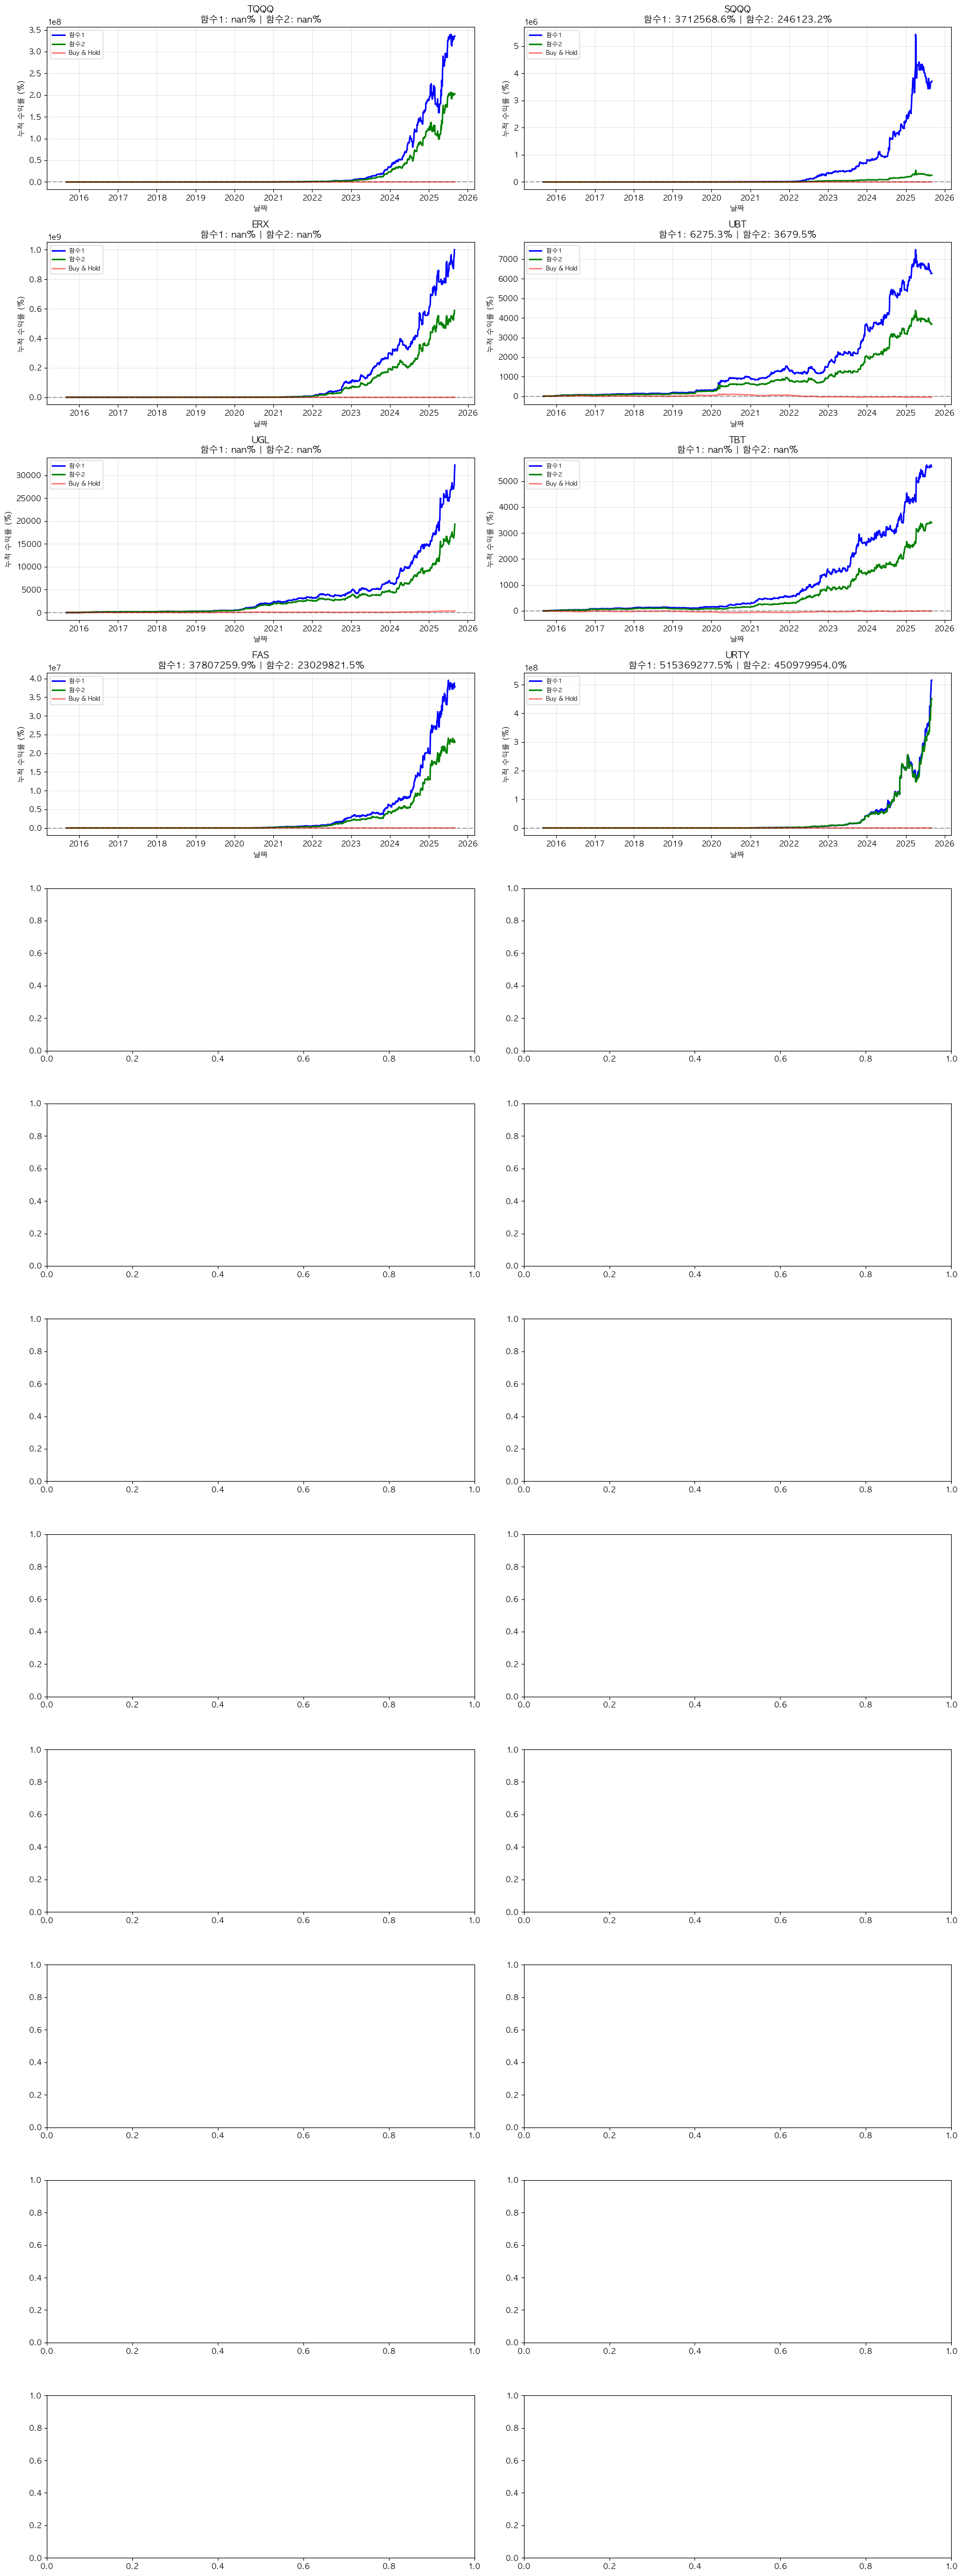

In [34]:

fig, axes = plt.subplots(12, 2, figsize=(18, 48))
axes = axes.flatten()

for idx, (ticker, results) in enumerate(comparison_results.items()):
    if idx < len(axes):
        ax = axes[idx]
        
        # ADX 필터만
        adx_only = results['adx_only']
        ax.plot(adx_only.index, (adx_only['cumulative_returns'] - 1) * 100, 
                label='함수1', linewidth=2, color='blue')
        
        # ADX/Chaikin 복합
        adx_chaikin = results['adx_chaikin']
        ax.plot(adx_chaikin.index, (adx_chaikin['cumulative_returns'] - 1) * 100, 
                label='함수2', linewidth=2, color='green')
        
        # Buy & Hold
        ax.plot(adx_only.index, (adx_only['buy_hold_returns'] - 1) * 100, 
                label='Buy & Hold', linewidth=2, color='red', alpha=0.5)
        
        # 최종 수익률 표시
        adx_final = (adx_only['cumulative_returns'].iloc[-1] - 1) * 100
        combo_final = (adx_chaikin['cumulative_returns'].iloc[-1] - 1) * 100

        ax.set_title(f'{ticker}\n함수1: {adx_final:.1f}% | 함수2: {combo_final:.1f}%', 
                    fontsize=12, fontweight='bold')
        ax.set_xlabel('날짜')
        ax.set_ylabel('누적 수익률 (%)')
        ax.legend(loc='best', fontsize=8)
        ax.grid(True, alpha=0.3)
        ax.axhline(y=0, color='black', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

### 5.3.2. 장중 신호 계산 테스트

In [27]:
# 개선된 상대모멘텀 함수 - CSV 저장 기능 추가
def calculate_momentum_portfolio_returns_with_csv(stock_data, strategy_func, momentum_period=20, 
                                       rebalance_period=30, top_n=3, save_csv=False, 
                                       csv_filename=None, calculate_today_signals=False,
                                       calculate_intraday_signals=False, **kwargs):
    """
    상대모멘텀을 적용한 포트폴리오 수익률 계산 (CSV 저장 및 장중 신호 기능 포함)
    
    Parameters:
    - save_csv: CSV 파일 저장 여부 (기본 False)
    - csv_filename: 저장할 CSV 파일명 (기본값: momentum_calculation_YYYYMMDD_HHMMSS.csv)
    - calculate_today_signals: 오늘 날짜 기준 필터 계산 여부 (기본 False)
    - calculate_intraday_signals: 장중 필터 계산 여부 (기본 False)
    """
    # 모든 종목의 결과 저장
    all_results = {}
    all_dates = None
    
    # 각 종목별 전략 실행
    for ticker, df in stock_data.items():
        result = strategy_func(df, **kwargs)
        all_results[ticker] = result
        
        if all_dates is None:
            all_dates = set(result.index)
        else:
            all_dates = all_dates.intersection(set(result.index))
    
    # 공통 날짜만 선택
    common_dates = sorted(list(all_dates))
    
    # 포트폴리오 일일 수익률 저장
    portfolio_returns = pd.Series(index=common_dates, dtype=float)
    portfolio_returns[:] = 0.0
    
    # 종목별 가중치 기록
    weights_history = pd.DataFrame(index=common_dates, columns=list(stock_data.keys()))
    weights_history[:] = 0.0
    
    # 리밸런싱 날짜 계산
    rebalance_dates = common_dates[::rebalance_period]
    
    # 상대모멘텀 계산과정 저장을 위한 리스트
    momentum_calculation_records = []
    
    # 각 리밸런싱 기간별 처리
    for i in range(len(rebalance_dates)):
        start_date = rebalance_dates[i]
        end_date = rebalance_dates[i + 1] if i + 1 < len(rebalance_dates) else common_dates[-1]
        
        # 모멘텀 계산을 위한 과거 수익률
        momentum_start_idx = common_dates.index(start_date) - momentum_period
        if momentum_start_idx < 0:
            momentum_start_idx = 0
        
        # 각 종목의 모멘텀 스코어 계산
        momentum_scores = {}
        momentum_details = {}
        
        for ticker, result in all_results.items():
            # 모멘텀 기간 동안의 가격 데이터
            momentum_prices = result['close'].loc[common_dates[momentum_start_idx]:start_date]
            
            if len(momentum_prices) >= 2:
                # 시작가격과 종료가격
                start_price = momentum_prices.iloc[0]
                end_price = momentum_prices.iloc[-1]
                
                # 모멘텀 수익률 계산
                momentum_return = (end_price / start_price - 1) if start_price > 0 else 0
                
                # NaN이나 inf 처리
                if pd.isna(momentum_return) or np.isinf(momentum_return):
                    momentum_return = 0
                
                momentum_scores[ticker] = momentum_return
                momentum_details[ticker] = {
                    'start_price': start_price,
                    'end_price': end_price,
                    'momentum_return': momentum_return,
                    'momentum_period_start': momentum_prices.index[0],
                    'momentum_period_end': momentum_prices.index[-1]
                }
            else:
                momentum_scores[ticker] = 0
                momentum_details[ticker] = {
                    'start_price': 0,
                    'end_price': 0,
                    'momentum_return': 0,
                    'momentum_period_start': None,
                    'momentum_period_end': None
                }
        
        # 상위 N개 종목 선택
        sorted_tickers = sorted(momentum_scores.items(), key=lambda x: x[1], reverse=True)
        selected_tickers = [ticker for ticker, _ in sorted_tickers[:top_n]]
        
        # 선택된 종목에 동일 가중
        weight = 1.0 / len(selected_tickers) if selected_tickers else 0
        
        # 리밸런싱 시점의 계산과정 기록
        for rank, (ticker, score) in enumerate(sorted_tickers):
            record = {
                'rebalance_date': start_date,
                'ticker': ticker,
                'rank': rank + 1,
                'momentum_score': score * 100,  # 퍼센트로 변환
                'momentum_period_start': momentum_details[ticker]['momentum_period_start'],
                'momentum_period_end': momentum_details[ticker]['momentum_period_end'],
                'start_price': momentum_details[ticker]['start_price'],
                'end_price': momentum_details[ticker]['end_price'],
                'selected': ticker in selected_tickers,
                'weight': weight if ticker in selected_tickers else 0,
                'rebalance_period_start': start_date,
                'rebalance_period_end': end_date
            }
            momentum_calculation_records.append(record)
        
        # 해당 기간 동안의 수익률 계산
        period_dates = [d for d in common_dates if start_date <= d <= end_date]
        
        for date in period_dates:
            daily_return = 0.0
            
            # 선택된 종목들의 수익률 가중 평균
            for ticker in selected_tickers:
                ticker_return = all_results[ticker].loc[date, 'returns']
                # NaN이나 inf 처리
                if pd.isna(ticker_return) or np.isinf(ticker_return):
                    ticker_return = 0
                daily_return += ticker_return * weight
                weights_history.loc[date, ticker] = weight
            
            portfolio_returns.loc[date] = daily_return
    
    # 누적 수익률 계산 (NaN 처리)
    clean_returns = portfolio_returns.replace([np.inf, -np.inf], 0).fillna(0)
    portfolio_cumulative = (1 + clean_returns).cumprod()
    
    # 상대모멘텀 계산과정을 DataFrame으로 변환
    momentum_calculation_df = pd.DataFrame(momentum_calculation_records)
    
    # 오늘 날짜 기준 필터 계산 (선택사항)
    today_signals_df = None
    if calculate_today_signals and len(common_dates) > 0:
        today_date = common_dates[-1]
        today_signals = []
        
        print(f"\n📊 오늘({today_date}) 기준 필터 계산:")
        print("=" * 80)
        
        for ticker in stock_data.keys():
            if ticker in all_results:
                result = all_results[ticker]
                
                # 모멘텀 스코어 계산
                if len(result) > momentum_period:
                    start_price = result['close'].iloc[-momentum_period-1]
                    current_price = result['close'].iloc[-1]
                    momentum_score = ((current_price - start_price) / start_price * 100) if start_price > 0 else 0
                else:
                    momentum_score = 0
                
                # 오늘의 필터 상태
                last_idx = result.index[-1]
                
                today_signal = {
                    'ticker': ticker,
                    'momentum_score': momentum_score,
                    'UPTREND': result.get('UPTREND', pd.Series(False)).loc[last_idx] if 'UPTREND' in result.columns else False,
                    'GREEN4': result.get('GREEN4', pd.Series(False)).loc[last_idx] if 'GREEN4' in result.columns else False,
                    'obv_filter': result.get('obv_filter', pd.Series(False)).loc[last_idx] if 'obv_filter' in result.columns else False,
                    'GREEN2': result.get('GREEN2', pd.Series(False)).loc[last_idx] if 'GREEN2' in result.columns else False,
                }
                today_signals.append(today_signal)
        
        today_signals_df = pd.DataFrame(today_signals)
        today_signals_df = today_signals_df.sort_values('momentum_score', ascending=False)
    
    # 장중 필터 계산 (선택사항)
    intraday_signals_df = None
    if calculate_intraday_signals and len(common_dates) > 1:
        intraday_signals = []
        yesterday_idx = -2
        
        print(f"\n📊 장중 사용 가능한 필터 상태 (어제 종가 기준):")
        print("=" * 80)
        
        for ticker in stock_data.keys():
            if ticker in all_results:
                result = all_results[ticker]
                
                # 어제 종가 기준 모멘텀
                if len(result) > momentum_period + 1:
                    yesterday_close = result['close'].iloc[yesterday_idx]
                    close_20d_ago = result['close'].iloc[yesterday_idx - momentum_period]
                    momentum_score = ((yesterday_close - close_20d_ago) / close_20d_ago * 100) if close_20d_ago > 0 else 0
                else:
                    momentum_score = 0
                
                # 어제의 필터 상태 (오늘 사용 가능)
                yesterday_data_idx = result.index[yesterday_idx]
                
                # 어제 Range (오늘 목표가 계산용)
                yesterday_range = result['high'].iloc[yesterday_idx] - result['low'].iloc[yesterday_idx]
                
                intraday_signal = {
                    'ticker': ticker,
                    'momentum_score': momentum_score,
                    'yesterday_close': result['close'].iloc[yesterday_idx],
                    'yesterday_range': yesterday_range,
                    'UPTREND_active': result.get('UPTREND', pd.Series(False)).loc[yesterday_data_idx] if 'UPTREND' in result.columns else False,
                    'GREEN4_active': result.get('GREEN4', pd.Series(False)).loc[yesterday_data_idx] if 'GREEN4' in result.columns else False,
                    'obv_filter_active': result.get('obv_filter', pd.Series(False)).loc[yesterday_data_idx] if 'obv_filter' in result.columns else False,
                    'GREEN2_active': result.get('GREEN2', pd.Series(False)).loc[yesterday_data_idx] if 'GREEN2' in result.columns else False,
                    'target_addon_k0.3': yesterday_range * 0.3,
                    'target_addon_k0.5': yesterday_range * 0.5,
                }
                intraday_signals.append(intraday_signal)
        
        intraday_signals_df = pd.DataFrame(intraday_signals)
        intraday_signals_df = intraday_signals_df.sort_values('momentum_score', ascending=False)
        
        # 상위 종목 출력
        print("\n모멘텀 상위 종목 (장중 사용):")
        for i, row in intraday_signals_df.head(top_n).iterrows():
            filters = []
            if row['UPTREND_active']: filters.append('ADX')
            if row['GREEN4_active']: filters.append('Chaikin')
            if row['obv_filter_active']: filters.append('OBV')
            if row['GREEN2_active']: filters.append('GREEN2')
            
            print(f"{row['ticker']:>6}: 모멘텀 {row['momentum_score']:>6.2f}% | 필터: {', '.join(filters) if filters else 'None'}")
            print(f"        목표가: 시가+{row['target_addon_k0.3']:.2f} (K=0.3), 시가+{row['target_addon_k0.5']:.2f} (K=0.5)")
    
    # CSV 저장 옵션이 켜져있으면 파일로 저장
    if save_csv:
        if csv_filename is None:
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            csv_filename = f"momentum_calculation_{timestamp}.csv"
        
        # 계산과정 CSV 저장
        momentum_calculation_df.to_csv(csv_filename, index=False, encoding='utf-8-sig')
        print(f"\n📊 상대모멘텀 계산과정이 '{csv_filename}'에 저장되었습니다.")
        
        # 추가로 일별 포트폴리오 가중치도 저장
        weights_filename = csv_filename.replace('.csv', '_weights.csv')
        weights_history.to_csv(weights_filename, encoding='utf-8-sig')
        print(f"📊 일별 포트폴리오 가중치가 '{weights_filename}'에 저장되었습니다.")
        
        # 장중 신호도 저장
        if calculate_intraday_signals and intraday_signals_df is not None:
            intraday_filename = csv_filename.replace('.csv', '_intraday.csv')
            intraday_signals_df.to_csv(intraday_filename, index=False, encoding='utf-8-sig')
            print(f"📊 장중 신호가 '{intraday_filename}'에 저장되었습니다.")
        
        # 요약 통계 출력
        print(f"\n📊 상대모멘텀 계산 요약:")
        print(f"- 총 리밸런싱 횟수: {len(rebalance_dates)}회")
        print(f"- 총 계산 레코드: {len(momentum_calculation_df)}개")
        print(f"- 분석 기간: {common_dates[0]} ~ {common_dates[-1]}")
        print(f"- 평균 모멘텀 스코어: {momentum_calculation_df['momentum_score'].mean():.2f}%")
        
        # 종목별 선택 빈도
        selection_stats = momentum_calculation_df[momentum_calculation_df['selected']].groupby('ticker').size()
        print(f"\n📊 종목별 포트폴리오 편입 횟수:")
        for ticker, count in selection_stats.sort_values(ascending=False).items():
            print(f"  - {ticker}: {count}회")
    
    return portfolio_returns, portfolio_cumulative, weights_history, momentum_calculation_df

### 5.2. 포트폴리오 통합 수익률 분석


=== 포트폴리오 성과 요약 (동일 가중) ===
포트폴리오 총 수익률: nan%
Buy & Hold 총 수익률: 166.25%
초과 수익률: nan%
포트폴리오 샤프 비율: nan
포트폴리오 MDD: -6.80%
포트폴리오 연환산 수익률: nan%
포트폴리오 변동성: 19.47%
포트폴리오 승률: 64.72%


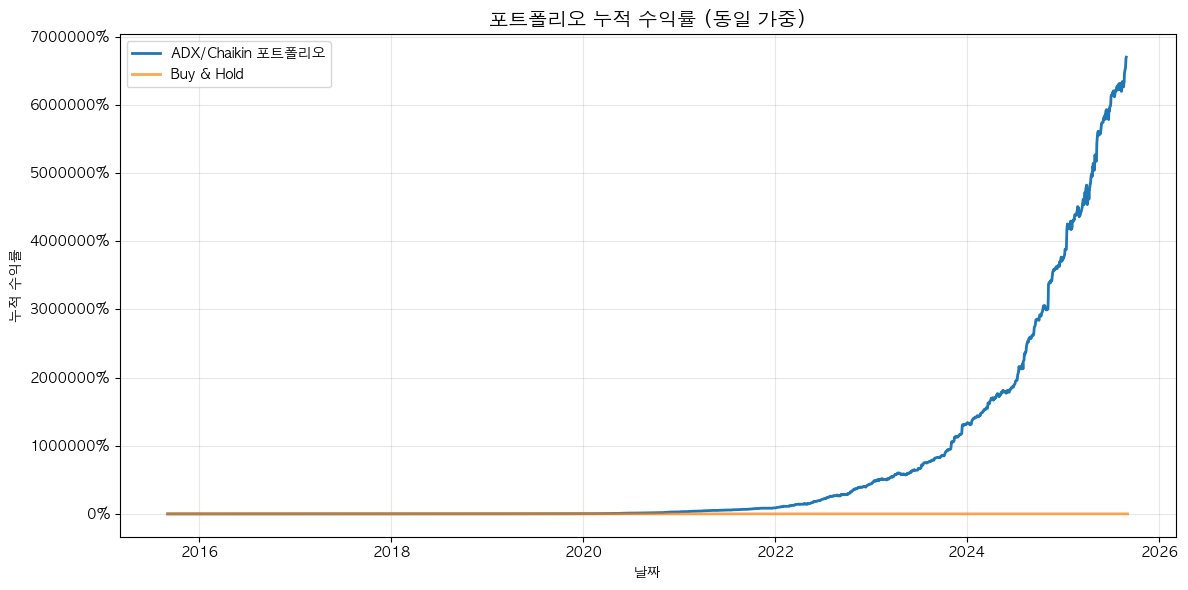

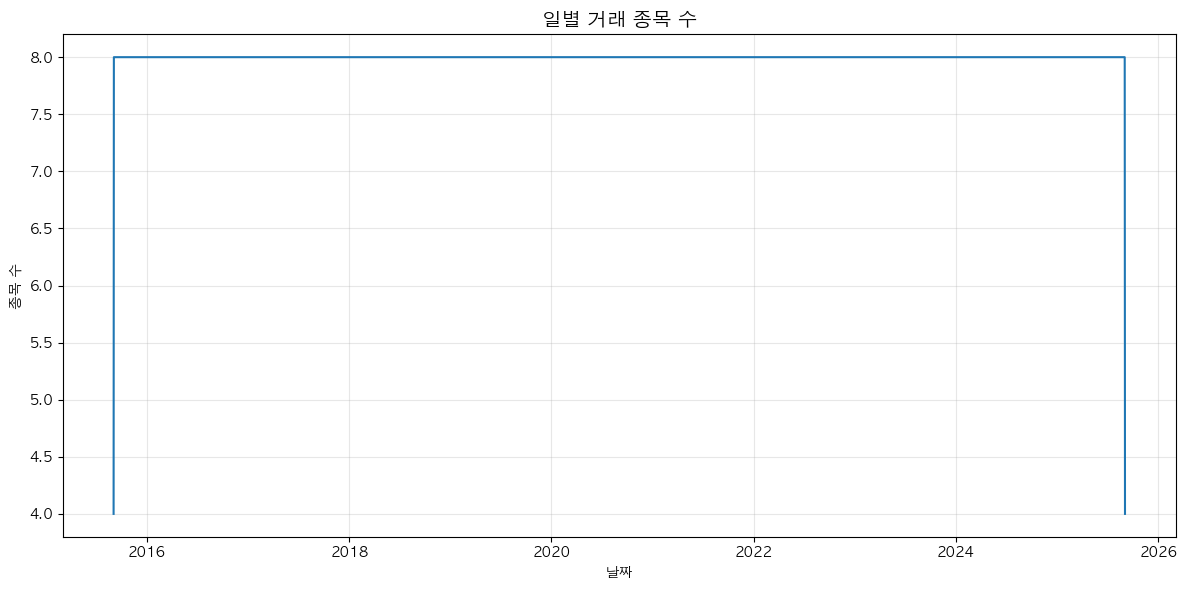

In [28]:
# 포트폴리오 수익률 계산 함수
def calculate_portfolio_returns(all_results, tickers):
    """여러 종목의 포트폴리오 수익률 계산 (동일 가중)"""
    # 모든 거래일 추출
    all_dates = set()
    for ticker in tickers:
        if ticker in all_results:
            all_dates.update(all_results[ticker].index)
    all_dates = sorted(all_dates)
    
    # 날짜별 포트폴리오 수익률 계산
    portfolio_data = []
    
    for date in all_dates:
        daily_returns = []
        buy_hold_returns = []
        
        for ticker in tickers:
            if ticker in all_results and date in all_results[ticker].index:
                daily_returns.append(all_results[ticker].loc[date, 'daily_return'])
                buy_hold_returns.append(all_results[ticker].loc[date, 'buy_hold_return'])
        
        if daily_returns:  # 해당 날짜에 데이터가 있는 경우만
            portfolio_data.append({
                'date': date,
                'portfolio_return': np.mean(daily_returns),
                'buy_hold_return': np.mean(buy_hold_returns),
                'active_tickers': len(daily_returns)
            })
    
    # DataFrame 생성
    df = pd.DataFrame(portfolio_data)
    df.set_index('date', inplace=True)
    
    # 누적 수익률 계산
    df['portfolio_cumulative'] = (1 + df['portfolio_return']).cumprod() - 1
    df['buy_hold_cumulative'] = (1 + df['buy_hold_return']).cumprod() - 1
    
    return df

# 성과 지표 계산 함수
def calculate_performance_metrics(returns, cumulative_returns):
    """성과 지표 계산"""
    if len(returns) == 0 or len(cumulative_returns) == 0:
        return {
            'total_return': 0,
            'annual_return': 0,
            'volatility': 0,
            'sharpe_ratio': 0,
            'mdd': 0,
            'win_rate': 0,
            'avg_win': 0,
            'avg_loss': 0,
            'trade_count': 0
        }
    
    try:
        # 기본 지표
        total_return = cumulative_returns.iloc[-1] if len(cumulative_returns) > 0 else 0
        
        # 연환산 수익률
        years = len(returns) / 252
        annual_return = (1 + total_return) ** (1/years) - 1 if years > 0 else 0
        
        # 변동성
        volatility = returns.std() * np.sqrt(252)
        
        # 샤프 비율
        sharpe_ratio = annual_return / volatility if volatility > 0 else 0
        
        # MDD
        cumulative_returns_series = pd.Series(cumulative_returns)
        running_max = cumulative_returns_series.expanding().max()
        drawdown = (cumulative_returns_series - running_max) / (1 + running_max)
        mdd = drawdown.min()
        
        # 승률
        wins = returns[returns > 0]
        losses = returns[returns < 0]
        win_rate = len(wins) / len(returns) if len(returns) > 0 else 0
        
        # 평균 손익
        avg_win = wins.mean() if len(wins) > 0 else 0
        avg_loss = losses.mean() if len(losses) > 0 else 0
        
        return {
            'total_return': total_return,
            'annual_return': annual_return,
            'volatility': volatility,
            'sharpe_ratio': sharpe_ratio,
            'mdd': mdd,
            'win_rate': win_rate,
            'avg_win': avg_win,
            'avg_loss': avg_loss,
            'trade_count': len(returns)
        }
    except Exception as e:
        print(f"성과 지표 계산 중 오류: {e}")
        return {
            'total_return': 0,
            'annual_return': 0,
            'volatility': 0,
            'sharpe_ratio': 0,
            'mdd': 0,
            'win_rate': 0,
            'avg_win': 0,
            'avg_loss': 0,
            'trade_count': 0
        }

# 포트폴리오 수익률 계산
cumulative_returns = calculate_portfolio_returns(all_results, selected_tickers)

# 성과 지표 계산
portfolio_metrics = calculate_performance_metrics(
    cumulative_returns['portfolio_return'], 
    cumulative_returns['portfolio_cumulative']
)
buy_hold_metrics = calculate_performance_metrics(
    cumulative_returns['buy_hold_return'], 
    cumulative_returns['buy_hold_cumulative']
)

# 8. 결과 시각화 - 1배열에 1개의 그래프, 순서 변경
# 8-1. 성과 지표 테이블
print("\n=== 포트폴리오 성과 요약 (동일 가중) ===")
print(f"포트폴리오 총 수익률: {portfolio_metrics['total_return']:.2%}")
print(f"Buy & Hold 총 수익률: {buy_hold_metrics['total_return']:.2%}")
print(f"초과 수익률: {portfolio_metrics['total_return'] - buy_hold_metrics['total_return']:.2%}")
print(f"포트폴리오 샤프 비율: {portfolio_metrics['sharpe_ratio']:.2f}")
print(f"포트폴리오 MDD: {portfolio_metrics['mdd']:.2%}")
print(f"포트폴리오 연환산 수익률: {portfolio_metrics['annual_return']:.2%}")
print(f"포트폴리오 변동성: {portfolio_metrics['volatility']:.2%}")
print(f"포트폴리오 승률: {portfolio_metrics['win_rate']:.2%}")

# 8-2. 누적 수익률 그래프
fig1 = plt.figure(figsize=(12, 6))
plt.plot(cumulative_returns.index, cumulative_returns['portfolio_cumulative'], 
        label='ADX/Chaikin 포트폴리오', linewidth=2)
plt.plot(cumulative_returns.index, cumulative_returns['buy_hold_cumulative'], 
        label='Buy & Hold', linewidth=2, alpha=0.7)
plt.title('포트폴리오 누적 수익률 (동일 가중)', fontsize=14)
plt.xlabel('날짜')
plt.ylabel('누적 수익률')
plt.legend()
plt.grid(True, alpha=0.3)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
plt.tight_layout()
plt.show()

# 8-3. 일별 거래 종목 수
fig2 = plt.figure(figsize=(12, 6))
plt.plot(cumulative_returns.index, cumulative_returns['active_tickers'])
plt.title('일별 거래 종목 수', fontsize=14)
plt.xlabel('날짜')
plt.ylabel('종목 수')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 5.3. 상대모멘텀 전략 시각화 (연간/월간 수익률 포함)


📊 상대모멘텀 포트폴리오 전략 분석:


/var/folders/v3/2dpbvf1x3v77928twwzc9jq80000gn/T/ipykernel_50466/737542318.py:57: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  momentum_returns = result['close'].shift(1).loc[common_dates[momentum_start_idx]:start_date].pct_change()



5일 모멘텀 Top5:
  총 수익률: 5214746.2%
  승률: 59.4%
  Sharpe Ratio: 8.92
  MDD: -11.6%


/var/folders/v3/2dpbvf1x3v77928twwzc9jq80000gn/T/ipykernel_50466/737542318.py:57: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  momentum_returns = result['close'].shift(1).loc[common_dates[momentum_start_idx]:start_date].pct_change()



10일 모멘텀 Top7:
  총 수익률: 3582102.0%
  승률: 63.1%
  Sharpe Ratio: 9.33
  MDD: -9.8%


/var/folders/v3/2dpbvf1x3v77928twwzc9jq80000gn/T/ipykernel_50466/737542318.py:57: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  momentum_returns = result['close'].shift(1).loc[common_dates[momentum_start_idx]:start_date].pct_change()



20일 모멘텀 Top10:
  총 수익률: 6776513.7%
  승률: 64.8%
  Sharpe Ratio: 10.54
  MDD: -6.2%

동일가중 (비교용):
  총 수익률: nan%
  Sharpe Ratio: nan
  MDD: -6.8%


/var/folders/v3/2dpbvf1x3v77928twwzc9jq80000gn/T/ipykernel_50466/737542318.py:279: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax4.boxplot(monthly_returns_data, labels=labels, patch_artist=True)


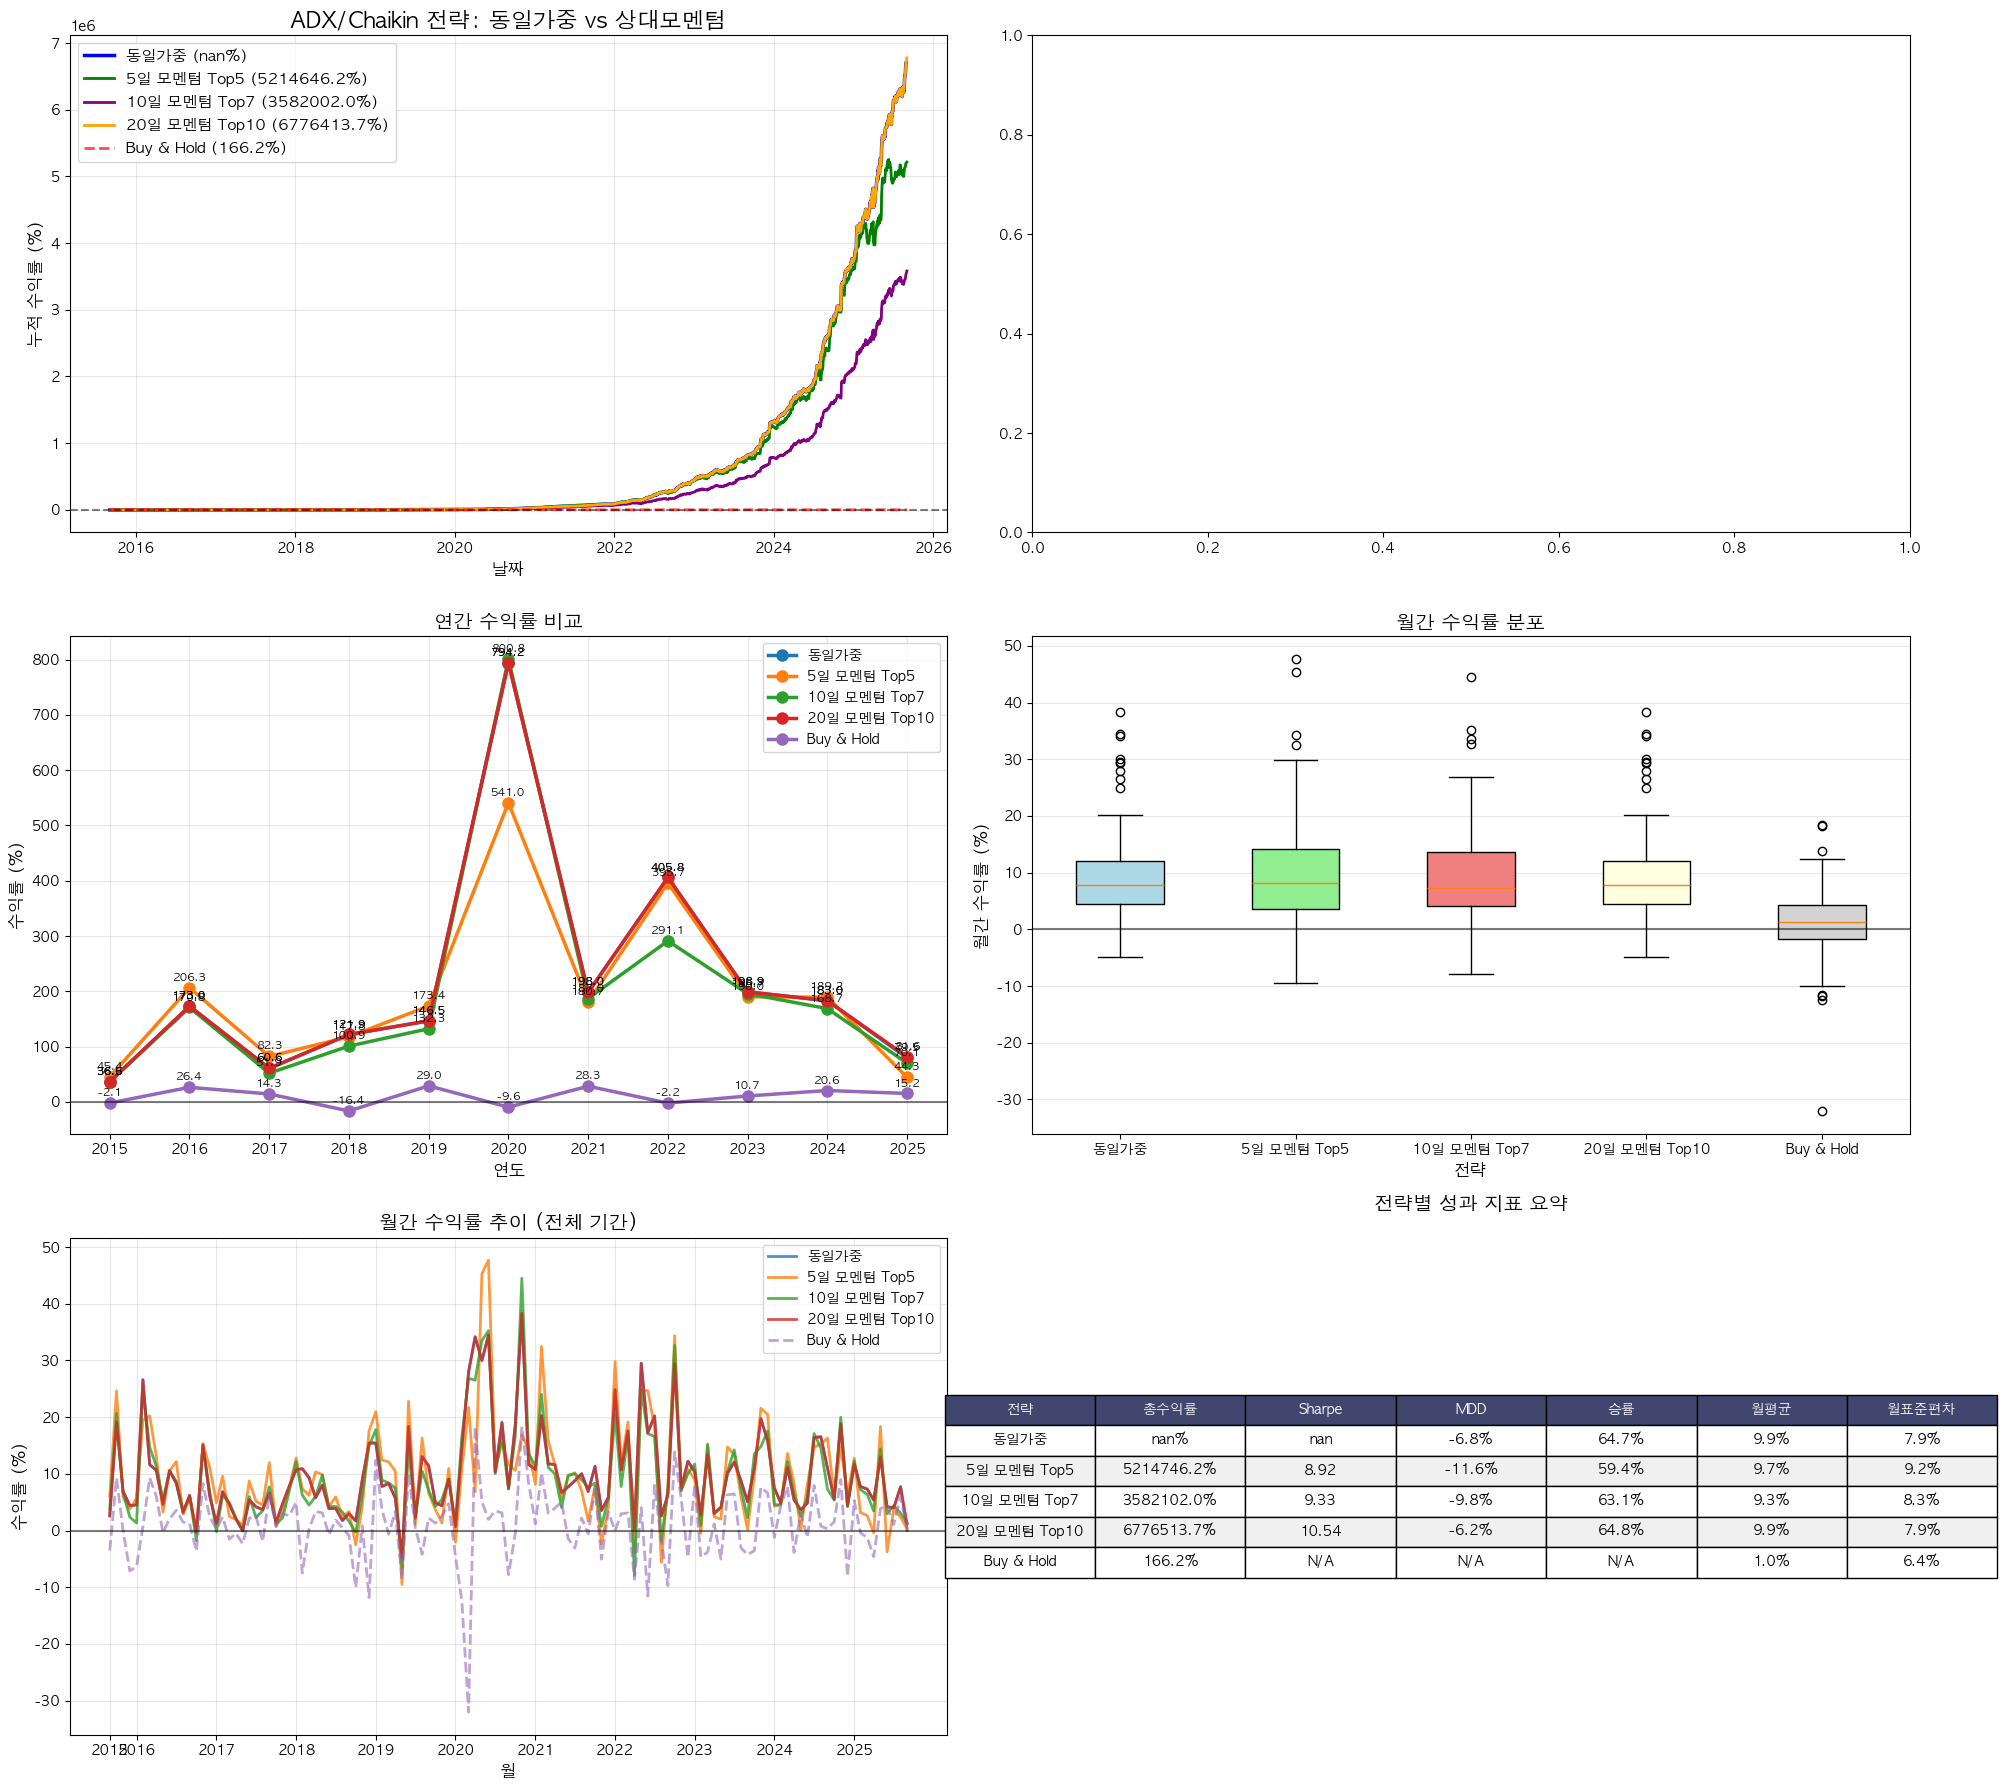


📊 포트폴리오 전략 성과 비교:
         전략          |     총수익률     |   Sharpe   |    MDD     |     승률    
----------------------------------------------------------------------------------------------------
        동일가중         |     nan    % |    nan     |   -6.8   % |   64.7   %
    5일 모멘텀 Top5      |  5214746.2 % |    8.92    |   -11.6  % |   59.4   %
    10일 모멘텀 Top7     |  3582102.0 % |    9.33    |   -9.8   % |   63.1   %
   20일 모멘텀 Top10     |  6776513.7 % |   10.54    |   -6.2   % |   64.8   %
     Buy & Hold      |    66.2    % |    N/A     |    N/A     |    N/A    


In [29]:
# 상대모멘텀을 적용한 포트폴리오 수익률 계산 함수
def calculate_momentum_portfolio_returns(stock_data, strategy_func, momentum_period=20, 
                                       rebalance_period=30, top_n=3, **kwargs):
    """
    상대모멘텀을 적용한 포트폴리오 수익률 계산
    
    Parameters:
    - stock_data: 종목 데이터 딕셔너리
    - strategy_func: 전략 함수
    - momentum_period: 모멘텀 계산 기간 (기본 20일)
    - rebalance_period: 리밸런싱 주기 (기본 20일)
    - top_n: 상위 n개 종목 선택 (기본 3개)
    - **kwargs: 전략 함수에 전달할 추가 인자
    """
    # 모든 종목의 결과 저장
    all_results = {}
    all_dates = None
    
    # 각 종목별 전략 실행
    for ticker, df in stock_data.items():
        result = strategy_func(df, **kwargs)
        all_results[ticker] = result
        
        if all_dates is None:
            all_dates = set(result.index)
        else:
            all_dates = all_dates.intersection(set(result.index))
    
    # 공통 날짜만 선택
    common_dates = sorted(list(all_dates))
    
    # 포트폴리오 일일 수익률 저장
    portfolio_returns = pd.Series(index=common_dates, dtype=float)
    portfolio_returns[:] = 0.0
    
    # 종목별 가중치 기록
    weights_history = pd.DataFrame(index=common_dates, columns=list(stock_data.keys()))
    weights_history[:] = 0.0
    
    # 리밸런싱 날짜 계산
    rebalance_dates = common_dates[::rebalance_period]
    
    # 각 리밸런싱 기간별 처리
    for i in range(len(rebalance_dates)):
        start_date = rebalance_dates[i]
        end_date = rebalance_dates[i + 1] if i + 1 < len(rebalance_dates) else common_dates[-1]
        
        # 모멘텀 계산을 위한 과거 수익률
        momentum_start_idx = common_dates.index(start_date) - momentum_period
        if momentum_start_idx < 0:
            momentum_start_idx = 0
        
        # 각 종목의 모멘텀 스코어 계산
        momentum_scores = {}
        for ticker, result in all_results.items():
            # 모멘텀 기간 동안의 수익률
            momentum_returns = result['close'].shift(1).loc[common_dates[momentum_start_idx]:start_date].pct_change()
            momentum_score = (1 + momentum_returns).prod() - 1
            # NaN이나 inf 처리
            if pd.isna(momentum_score) or np.isinf(momentum_score):
                momentum_score = 0
            momentum_scores[ticker] = momentum_score
        
        # 상위 N개 종목 선택
        sorted_tickers = sorted(momentum_scores.items(), key=lambda x: x[1], reverse=True)
        selected_tickers = [ticker for ticker, _ in sorted_tickers[:top_n]]
        
        # 선택된 종목에 동일 가중
        weight = 1.0 / len(selected_tickers) if selected_tickers else 0
        
        # 해당 기간 동안의 수익률 계산
        period_dates = [d for d in common_dates if start_date <= d <= end_date]
        
        for date in period_dates:
            daily_return = 0.0
            
            # 선택된 종목들의 수익률 가중 평균
            for ticker in selected_tickers:
                ticker_return = all_results[ticker].loc[date, 'returns']
                # NaN이나 inf 처리
                if pd.isna(ticker_return) or np.isinf(ticker_return):
                    ticker_return = 0
                daily_return += ticker_return * weight
                weights_history.loc[date, ticker] = weight
            
            portfolio_returns.loc[date] = daily_return
    
    # 누적 수익률 계산 (NaN 처리)
    clean_returns = portfolio_returns.replace([np.inf, -np.inf], 0).fillna(0)
    portfolio_cumulative = (1 + clean_returns).cumprod()
    
    return portfolio_returns, portfolio_cumulative, weights_history

# 동일가중 포트폴리오 vs 상대모멘텀 포트폴리오 비교
print("\n📊 상대모멘텀 포트폴리오 전략 분석:")
print("=" * 80)

# 상대모멘텀 포트폴리오 - 다양한 설정
momentum_configs = [
    {'period': 5, 'top_n': 5, 'name': '5일 모멘텀 Top5'},
    {'period': 10, 'top_n': 7, 'name': '10일 모멘텀 Top7'},
    {'period': 20, 'top_n': 10, 'name': '20일 모멘텀 Top10'}
]

momentum_results = {}

for config in momentum_configs:
    mom_daily, mom_cumulative, weights = calculate_momentum_portfolio_returns(
        stock_data, 
        volatility_breakout_with_all_filters_v5, 
        momentum_period=config['period'],
        top_n=config['top_n'],
        k=k_value,
        adx_threshold=adx_threshold,
        slippage=slippage,
        commission=commission,
        
    )
    
    momentum_results[config['name']] = {
        'daily': mom_daily,
        'cumulative': mom_cumulative,
        'weights': weights
    }
    
    # 성과 지표 계산
    metrics = calculate_performance_metrics(mom_daily, mom_cumulative)
    
    print(f"\n{config['name']}:")
    print(f"  총 수익률: {metrics['total_return']*100:.1f}%")
    print(f"  승률: {metrics['win_rate']*100:.1f}%")
    print(f"  Sharpe Ratio: {metrics['sharpe_ratio']:.2f}")
    print(f"  MDD: {metrics['mdd']*100:.1f}%")

# 동일가중 성과
if 'cumulative_returns' in locals() and not cumulative_returns.empty:
    equal_weight_metrics = calculate_performance_metrics(
        cumulative_returns['portfolio_return'], 
        cumulative_returns['portfolio_cumulative']
    )
    print(f"\n동일가중 (비교용):")
    print(f"  총 수익률: {equal_weight_metrics['total_return']*100:.1f}%")
    print(f"  Sharpe Ratio: {equal_weight_metrics['sharpe_ratio']:.2f}")
    print(f"  MDD: {equal_weight_metrics['mdd']*100:.1f}%")
else:
    print("\n동일가중 포트폴리오 데이터가 없습니다.")
    equal_weight_metrics = None

print("=" * 80)

# 시각화 - 확장된 버전 (연간/월간 수익률 포함)
if momentum_results:
    # 더 큰 그림 생성 (3x2 레이아웃)
    fig = plt.figure(figsize=(20, 18))
    
    # 1. 누적 수익률 곡선
    ax1 = plt.subplot(3, 2, 1)
    
    # 동일가중 포트폴리오
    if 'cumulative_returns' in locals() and not cumulative_returns.empty:
        total_return = cumulative_returns['portfolio_cumulative'].iloc[-1] * 100
        ax1.plot(cumulative_returns.index, cumulative_returns['portfolio_cumulative'] * 100, 
                 label=f'동일가중 ({total_return:.1f}%)', 
                 linewidth=2.5, color='blue')

    # 상대모멘텀 포트폴리오들
    colors = ['green', 'purple', 'orange']
    for i, (name, results) in enumerate(momentum_results.items()):
        total_return = (results['cumulative'].iloc[-1] - 1) * 100
        ax1.plot(results['cumulative'].index, (results['cumulative'] - 1) * 100,
                 label=f'{name} ({total_return:.1f}%)',
                 linewidth=2, color=colors[i])

    # Buy & Hold (참고용)
    if 'cumulative_returns' in locals() and 'buy_hold_cumulative' in cumulative_returns.columns:
        bh_return = cumulative_returns['buy_hold_cumulative'].iloc[-1] * 100
        ax1.plot(cumulative_returns.index, cumulative_returns['buy_hold_cumulative'] * 100, 
                 label=f'Buy & Hold ({bh_return:.1f}%)', 
                 linewidth=2, color='red', linestyle='--', alpha=0.7)

    ax1.set_title('ADX/Chaikin 전략: 동일가중 vs 상대모멘텀', fontsize=16, fontweight='bold')
    ax1.set_xlabel('날짜', fontsize=12)
    ax1.set_ylabel('누적 수익률 (%)', fontsize=12)
    ax1.legend(loc='best', fontsize=11)
    ax1.grid(True, alpha=0.3)
    ax1.axhline(y=0, color='black', linestyle='--', alpha=0.5)

    # 2. 종목별 포트폴리오 편입 빈도 (막대 그래프)
    ax2 = plt.subplot(3, 2, 2)
    
    if '20일 모멘텀 Top3' in momentum_results:
        weights = momentum_results['20일 모멘텀 Top3']['weights']
        selection_counts = (weights > 0).sum()
        selection_counts = selection_counts[selection_counts > 0].sort_values(ascending=False)

        if len(selection_counts) > 0:
            ax2.bar(range(len(selection_counts)), selection_counts.values, 
                    color='skyblue', alpha=0.8)
            ax2.set_xticks(range(len(selection_counts)))
            ax2.set_xticklabels(selection_counts.index, rotation=45)
            ax2.set_title('상대모멘텀 Top3 포트폴리오 편입 빈도', fontsize=14, fontweight='bold')
            ax2.set_xlabel('종목', fontsize=12)
            ax2.set_ylabel('포트폴리오 편입 일수', fontsize=12)
            ax2.grid(True, alpha=0.3, axis='y')

            # 포트폴리오 편입 비율 표시
            for i, (ticker, count) in enumerate(selection_counts.items()):
                ratio = count / len(weights) * 100
                ax2.text(i, count + 5, f'{ratio:.1f}%', ha='center', va='bottom')

    # 3. 연간 수익률 비교 (선형 그래프)
    ax3 = plt.subplot(3, 2, 3)
    
    yearly_returns = pd.DataFrame()
    
    # 동일가중 연간 수익률
    if 'cumulative_returns' in locals() and not cumulative_returns.empty:
        yearly_returns['동일가중'] = cumulative_returns['portfolio_return'].resample('YE').apply(lambda x: (1 + x).prod() - 1) * 100
    
    # 모멘텀 전략 연간 수익률
    for name, results in momentum_results.items():
        yearly_returns[name] = results['daily'].resample('YE').apply(lambda x: (1 + x).prod() - 1) * 100
    
    # Buy & Hold 연간 수익률
    if 'cumulative_returns' in locals() and 'buy_hold_return' in cumulative_returns.columns:
        yearly_returns['Buy & Hold'] = cumulative_returns['buy_hold_return'].resample('YE').apply(lambda x: (1 + x).prod() - 1) * 100
    
    # 연도 레이블을 간단하게 변경
    yearly_returns.index = yearly_returns.index.year
    
    # 선형 그래프 생성
    for column in yearly_returns.columns:
        ax3.plot(yearly_returns.index, yearly_returns[column], 
                marker='o', linewidth=2.5, markersize=8, label=column)
    
    ax3.set_title('연간 수익률 비교', fontsize=14, fontweight='bold')
    ax3.set_xlabel('연도', fontsize=12)
    ax3.set_ylabel('수익률 (%)', fontsize=12)
    ax3.legend(loc='best', fontsize=10)
    ax3.grid(True, alpha=0.3)
    ax3.axhline(y=0, color='black', linestyle='-', alpha=0.5)
    
    # x축에 모든 연도 표시
    ax3.set_xticks(yearly_returns.index)
    ax3.set_xticklabels(yearly_returns.index)
    
    # 각 포인트에 값 표시
    for column in yearly_returns.columns:
        for x, y in zip(yearly_returns.index, yearly_returns[column]):
            if pd.notna(y):  # NaN이 아닌 경우만 표시
                ax3.annotate(f'{y:.1f}', (x, y), textcoords="offset points", 
                            xytext=(0,5), ha='center', fontsize=8)
    
    # 4. 월간 수익률 분포 (박스플롯)
    ax4 = plt.subplot(3, 2, 4)
    
    monthly_returns_data = []
    labels = []
    
    # 동일가중 월간 수익률
    if 'cumulative_returns' in locals() and not cumulative_returns.empty:
        monthly_eq = cumulative_returns['portfolio_return'].resample('ME').apply(lambda x: (1 + x).prod() - 1) * 100
        monthly_returns_data.append(monthly_eq.values)
        labels.append('동일가중')
    
    # 모멘텀 전략 월간 수익률
    for name, results in momentum_results.items():
        monthly_mom = results['daily'].resample('ME').apply(lambda x: (1 + x).prod() - 1) * 100
        monthly_returns_data.append(monthly_mom.values)
        labels.append(name)
    
    # Buy & Hold 월간 수익률
    if 'cumulative_returns' in locals() and 'buy_hold_return' in cumulative_returns.columns:
        monthly_bh = cumulative_returns['buy_hold_return'].resample('ME').apply(lambda x: (1 + x).prod() - 1) * 100
        monthly_returns_data.append(monthly_bh.values)
        labels.append('Buy & Hold')
    
    # 박스플롯 생성
    bp = ax4.boxplot(monthly_returns_data, labels=labels, patch_artist=True)
    
    # 색상 설정
    colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightyellow', 'lightgray']
    for patch, color in zip(bp['boxes'], colors[:len(bp['boxes'])]):
        patch.set_facecolor(color)
    
    ax4.set_title('월간 수익률 분포', fontsize=14, fontweight='bold')
    ax4.set_xlabel('전략', fontsize=12)
    ax4.set_ylabel('월간 수익률 (%)', fontsize=12)
    ax4.grid(True, alpha=0.3, axis='y')
    ax4.axhline(y=0, color='black', linestyle='-', alpha=0.5)
    
    # 5. 전체 기간 월간 수익률 (선형 그래프) - 모든 전략 포함
    ax5 = plt.subplot(3, 2, 5)
    
    # 전체 월간 데이터
    all_monthly = pd.DataFrame()
    
    # 동일가중 월간 수익률
    if 'cumulative_returns' in locals() and not cumulative_returns.empty:
        all_monthly['동일가중'] = cumulative_returns['portfolio_return'].resample('ME').apply(lambda x: (1 + x).prod() - 1) * 100
    
    # 모든 모멘텀 전략의 월간 수익률
    colors_monthly = ['green', 'purple', 'orange']
    for i, (name, results) in enumerate(momentum_results.items()):
        all_monthly[name] = results['daily'].resample('ME').apply(lambda x: (1 + x).prod() - 1) * 100
    
    # Buy & Hold 월간 수익률
    if 'cumulative_returns' in locals() and 'buy_hold_return' in cumulative_returns.columns:
        all_monthly['Buy & Hold'] = cumulative_returns['buy_hold_return'].resample('ME').apply(lambda x: (1 + x).prod() - 1) * 100
    
    # 선형 그래프 생성
    line_styles = ['-', '-', '-', '-', '--']
    alphas = [0.8, 0.8, 0.8, 0.8, 0.6]
    
    for i, column in enumerate(all_monthly.columns):
        ax5.plot(all_monthly.index, all_monthly[column], 
                linewidth=2, label=column, 
                linestyle=line_styles[i] if i < len(line_styles) else '-',
                alpha=alphas[i] if i < len(alphas) else 0.8)
    
    ax5.set_title('월간 수익률 추이 (전체 기간)', fontsize=14, fontweight='bold')
    ax5.set_xlabel('월', fontsize=12)
    ax5.set_ylabel('수익률 (%)', fontsize=12)
    ax5.legend(loc='best', fontsize=10)
    ax5.grid(True, alpha=0.3)
    ax5.axhline(y=0, color='black', linestyle='-', alpha=0.5)
    
    # x축 포맷 설정 (연도 표시)
    years = all_monthly.index.year.unique()
    year_starts = []
    year_labels = []
    for year in years:
        year_data = all_monthly[all_monthly.index.year == year]
        if len(year_data) > 0:
            year_starts.append(year_data.index[0])
            year_labels.append(str(year))
    
    ax5.set_xticks(year_starts)
    ax5.set_xticklabels(year_labels)
    
    # 6. 전략별 성과 지표 테이블
    ax6 = plt.subplot(3, 2, 6)
    ax6.axis('tight')
    ax6.axis('off')
    
    # 테이블 데이터 준비
    table_data = []
    table_columns = ['전략', '총수익률', 'Sharpe', 'MDD', '승률', '월평균', '월표준편차']
    
    # 동일가중
    if 'cumulative_returns' in locals() and not cumulative_returns.empty:
        monthly_eq = cumulative_returns['portfolio_return'].resample('ME').apply(lambda x: (1 + x).prod() - 1) * 100
        table_data.append([
            '동일가중',
            f"{equal_weight_metrics['total_return']*100:.1f}%",
            f"{equal_weight_metrics['sharpe_ratio']:.2f}",
            f"{equal_weight_metrics['mdd']*100:.1f}%",
            f"{equal_weight_metrics['win_rate']*100:.1f}%",
            f"{monthly_eq.mean():.1f}%",
            f"{monthly_eq.std():.1f}%"
        ])
    
    # 모멘텀 전략들
    for name, results in momentum_results.items():
        metrics = calculate_performance_metrics(results['daily'], results['cumulative'])
        monthly_returns = results['daily'].resample('ME').apply(lambda x: (1 + x).prod() - 1) * 100
        
        table_data.append([
            name,
            f"{metrics['total_return']*100:.1f}%",
            f"{metrics['sharpe_ratio']:.2f}",
            f"{metrics['mdd']*100:.1f}%",
            f"{metrics['win_rate']*100:.1f}%",
            f"{monthly_returns.mean():.1f}%",
            f"{monthly_returns.std():.1f}%"
        ])
    
    # Buy & Hold
    if 'cumulative_returns' in locals() and 'buy_hold_cumulative' in cumulative_returns.columns:
        bh_return = cumulative_returns['buy_hold_cumulative'].iloc[-1] * 100
        monthly_bh = cumulative_returns['buy_hold_return'].resample('ME').apply(lambda x: (1 + x).prod() - 1) * 100
        table_data.append([
            'Buy & Hold',
            f"{bh_return:.1f}%",
            'N/A',
            'N/A',
            'N/A',
            f"{monthly_bh.mean():.1f}%",
            f"{monthly_bh.std():.1f}%"
        ])
    
    # 테이블 생성
    table = ax6.table(cellText=table_data,
                      colLabels=table_columns,
                      cellLoc='center',
                      loc='center')
    
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.5)
    
    # 헤더 스타일
    for i in range(len(table_columns)):
        table[(0, i)].set_facecolor('#40466e')
        table[(0, i)].set_text_props(weight='bold', color='white')
    
    # 행 색상 교대로
    for i in range(1, len(table_data) + 1):
        if i % 2 == 0:
            for j in range(len(table_columns)):
                table[(i, j)].set_facecolor('#f0f0f0')
    
    ax6.set_title('전략별 성과 지표 요약', fontsize=14, fontweight='bold', pad=20)
    
    plt.tight_layout()
    plt.show()

    # 성과 비교 테이블 (텍스트)
    print("\n📊 포트폴리오 전략 성과 비교:")
    print("=" * 100)
    print(f"{'전략':^20} | {'총수익률':^12} | {'Sharpe':^10} | {'MDD':^10} | {'승률':^10}")
    print("-" * 100)

    # 동일가중
    if equal_weight_metrics:
        print(f"{'동일가중':^20} | {equal_weight_metrics['total_return']*100:^11.1f}% | "
              f"{equal_weight_metrics['sharpe_ratio']:^10.2f} | {equal_weight_metrics['mdd']*100:^9.1f}% | "
              f"{equal_weight_metrics['win_rate']*100:^9.1f}%")

    # 상대모멘텀
    for name, results in momentum_results.items():
        metrics = calculate_performance_metrics(results['daily'], results['cumulative'])
        print(f"{name:^20} | {metrics['total_return']*100:^11.1f}% | "
              f"{metrics['sharpe_ratio']:^10.2f} | {metrics['mdd']*100:^9.1f}% | "
              f"{metrics['win_rate']*100:^9.1f}%")

    # Buy & Hold
    if 'cumulative_returns' in locals() and 'buy_hold_cumulative' in cumulative_returns.columns:
        bh_return = (cumulative_returns['buy_hold_cumulative'].iloc[-1] - 1) * 100
        print(f"{'Buy & Hold':^20} | {bh_return:^11.1f}% | {'N/A':^10} | {'N/A':^10} | {'N/A':^10}")
    print("=" * 100)

##### 오늘 매매할 종목 출력

In [30]:
# 오늘의 매매 신호 분석 테스트
recommendation = analyze_today_signals(stock_data, volatility_breakout_with_all_filters_v5, 
                                     lookback_days=10, k=0.3, adx_threshold=35)

# 결과 요약 출력
print("\n" + "="*60)
print("📊 분석 결과 요약")
print("="*60)
print(f"시장 상태:")
print(f"  - 필터 충족 비율: {recommendation['market_condition']['filter_ratio']:.1f}%")
print(f"  - 평균 모멘텀: {recommendation['market_condition']['avg_momentum']:.2f}%")
print(f"  - 최근 10일 평균 수익률: {recommendation['market_condition']['avg_returns_10d']:.3f}%")
print(f"\n추천 액션: {recommendation['action']}")
print(f"매수 후보 종목 수: {len(recommendation['candidates'])}")

if len(recommendation['candidates']) > 0:
    print("\n매수 후보:")
    for candidate in recommendation['candidates']:
        print(f"  - {candidate['ticker']}: 모멘텀 {candidate['momentum_score']:.2f}%")


                           📊 오늘의 매매 신호 분석 (최근 10일 기준)                           
분석 시간: 2025-09-04 15:24:34
분석 설정: K=0.3, ADX=35, 모멘텀기간=20일
--------------------------------------------------------------------------------

📈 시장 상황 분석:
--------------------------------------------------------------------------------
✓ 전체 8개 종목 중 4개(50.0%)가 필터 조건 충족
✓ 평균 모멘텀: 6.39% (양수: 6/8)
✓ 최근 10일 평균 일수익률: 0.993%

🎯 오늘의 매매 추천:
--------------------------------------------------------------------------------

✅ 매수 후보 종목 (2개):

  🎯 ERX (모멘텀 2위)
     - 모멘텀: 11.62%
     - 현재가: $57.64
     - 목표가: $57.45
     - 활성 필터: obv_filter, macd_filter
     - RSI: 70.3
     - MACD 히스토그램: 0.6764
     - 최근 10일: 매수신호 9회, 평균수익 1.698%
     - 추세강도: 1.416%/일
     - 10일간 필터활성: obv_filter(7일), macd_filter(11일), rsi_filter(6일)

  🎯 UGL (모멘텀 3위)
     - 모멘텀: 11.23%
     - 현재가: $39.92
     - 목표가: $40.45
     - 활성 필터: obv_filter, macd_filter, rsi_filter
     - RSI: 75.7
     - MACD 히스토그램: 0.5060
     - 최근 10일: 매수신호 8회, 평균수익 2.173%
  

#### 5.3.1. 리밸런싱 날짜 산출

In [31]:
# CSV 저장 기능을 포함한 상대모멘텀 계산 테스트
print("\n📊 상대모멘텀 계산과정을 CSV로 저장하는 테스트:")
print("=" * 80)

# 기존 함수 대신 새로운 함수 사용
mom_daily_csv, mom_cumulative_csv, weights_csv, momentum_df = calculate_momentum_portfolio_returns_with_csv(
    stock_data,
    volatility_breakout_with_all_filters_v4,
    momentum_period=20,
    top_n=3,
    rebalance_period=30,
    k=k_value,
    adx_threshold=adx_threshold,
    save_csv=True,  # CSV 저장 켜기
    csv_filename='momentum_calculation_top_safe_etf.csv'
)

# CSV 파일 내용 확인
print(f"\n📊 저장된 CSV 파일 구조 (처음 10행):")
print(momentum_df.head(10))

# 최근 리밸런싱 상세 정보
print(f"\n📊 가장 최근 리밸런싱 상세 정보:")
latest_rebalance = momentum_df['rebalance_date'].max()
latest_data = momentum_df[momentum_df['rebalance_date'] == latest_rebalance]

print(f"\n리밸런싱 날짜: {latest_rebalance}")
print(latest_data[['ticker', 'rank', 'momentum_score', 'selected', 'weight']].to_string())

# 종목별 평균 모멘텀 스코어
ticker_momentum_stats = momentum_df.groupby('ticker')['momentum_score'].agg(['mean', 'std', 'count'])
print(f"\n📊 종목별 평균 모멘텀 스코어:")
print(ticker_momentum_stats.sort_values('mean', ascending=False))

# 선택된 종목 vs 선택되지 않은 종목의 모멘텀 비교
selected_momentum = momentum_df[momentum_df['selected']]['momentum_score'].mean()
not_selected_momentum = momentum_df[~momentum_df['selected']]['momentum_score'].mean()

print(f"\n📊 모멘텀 스코어 비교:")
print(f"- 선택된 종목 평균: {selected_momentum:.2f}%")
print(f"- 선택되지 않은 종목 평균: {not_selected_momentum:.2f}%")
print(f"- 차이: {selected_momentum - not_selected_momentum:.2f}%p")

print(f"\n✅ CSV 파일이 성공적으로 저장되었습니다!")
print(f"- 계산과정: momentum_calculation_top_safe_etf.csv")
print(f"- 일별 가중치: momentum_calculation_top_safe_etf_weights.csv")


📊 상대모멘텀 계산과정을 CSV로 저장하는 테스트:

📊 상대모멘텀 계산과정이 'momentum_calculation_top_safe_etf.csv'에 저장되었습니다.
📊 일별 포트폴리오 가중치가 'momentum_calculation_top_safe_etf_weights.csv'에 저장되었습니다.

📊 상대모멘텀 계산 요약:
- 총 리밸런싱 횟수: 84회
- 총 계산 레코드: 672개
- 분석 기간: 2015-09-04 00:00:00 ~ 2025-09-02 00:00:00
- 평균 모멘텀 스코어: 1.56%

📊 종목별 포트폴리오 편입 횟수:
  - TQQQ: 46회
  - FAS: 41회
  - URTY: 38회
  - ERX: 36회
  - UGL: 25회
  - UBT: 24회
  - SQQQ: 23회
  - TBT: 19회

📊 저장된 CSV 파일 구조 (처음 10행):
  rebalance_date ticker  rank  momentum_score momentum_period_start  \
0     2015-09-04   TQQQ     1        0.000000                   NaT   
1     2015-09-04   SQQQ     2        0.000000                   NaT   
2     2015-09-04    ERX     3        0.000000                   NaT   
3     2015-09-04    UBT     4        0.000000                   NaT   
4     2015-09-04    UGL     5        0.000000                   NaT   
5     2015-09-04    TBT     6        0.000000                   NaT   
6     2015-09-04    FAS     7        0.000000              

#### 5.3.2 상대모멘텀 종목별 선택 빈도 분석

In [32]:
# 상대모멘텀 종목별 포트폴리오 편입 빈도 분석
print("\n📊 상대모멘텀 전략 종목별 포트폴리오 편입 빈도:")
print("=" * 80)

# momentum_results가 정의되어 있는지 확인
if 'momentum_results' not in locals():
    print("먼저 상대모멘텀 전략을 실행해주세요 (이전 셀 실행)")
else:
    for name, results in momentum_results.items():
        weights = results['weights']
        
        # 각 종목이 포트폴리오에 편입된 일수 계산
        selection_days = (weights > 0).sum()
        total_days = len(weights)
        
        # 포트폴리오 편입 빈도가 높은 순으로 정렬
        sorted_tickers = selection_days.sort_values(ascending=False)
        
        print(f"\n{name}:")
        print(f"{'순위':^6} | {'티커':^10} | {'편입일수':^10} | {'편입비율':^10}")
        print("-" * 40)
        
        for i, (ticker, days) in enumerate(sorted_tickers.items()):
            if days > 0:
                ratio = days / total_days * 100
                print(f"{i+1:^6} | {ticker:^10} | {days:^10} | {ratio:^9.1f}%")

# 월별 수익률 분석
print("\n\n📊 월별 수익률 비교:")
print("=" * 80)

# 월별 수익률 계산 함수
def calculate_monthly_returns(daily_returns, cumulative_returns):
    monthly_returns = daily_returns.resample('M').apply(lambda x: (1 + x).prod() - 1) * 100
    return monthly_returns

if 'cumulative_returns' in locals() and 'momentum_results' in locals() and not cumulative_returns.empty:
    # 동일가중 월별 수익률
    equal_monthly = calculate_monthly_returns(
        cumulative_returns['portfolio_return'], 
        cumulative_returns['portfolio_cumulative']
    )

    # 최고 성과 모멘텀 전략 선택 (20일 모멘텀 Top3)
    if '20일 모멘텀 Top3' in momentum_results:
        best_momentum = momentum_results['20일 모멘텀 Top3']
        mom_monthly = calculate_monthly_returns(best_momentum['daily'], best_momentum['cumulative'])

        # 월별 비교
        comparison_df = pd.DataFrame({
            '동일가중': equal_monthly,
            '모멘텀Top3': mom_monthly
        })
        comparison_df['초과수익'] = comparison_df['모멘텀Top3'] - comparison_df['동일가중']

        print(comparison_df.tail(12))  # 최근 12개월
else:
    print("포트폴리오 데이터가 없습니다. 먼저 포트폴리오 분석을 실행하세요.")

# 진입 유형별 통계 (ADX/Chaikin 복합 필터)
print("\n\n📊 모멘텀 포트폴리오 편입 종목의 진입 유형 분석:")
print("=" * 80)

if 'momentum_results' in locals() and 'all_results' in locals() and '20일 모멘텀 Top3' in momentum_results:
    # 20일 모멘텀 Top3 전략의 편입된 종목들 분석
    best_momentum_weights = momentum_results['20일 모멘텀 Top3']['weights']
    selected_dates = best_momentum_weights.index[best_momentum_weights.sum(axis=1) > 0]

    entry_type_stats = {
        'ADX': 0,
        'Chaikin': 0,
        'Both': 0,
        'Total': 0
    }

    for date in selected_dates:
        selected_tickers = best_momentum_weights.columns[best_momentum_weights.loc[date] > 0]
        
        for ticker in selected_tickers:
            if ticker in all_results and date in all_results[ticker].index:
                if all_results[ticker].loc[date, 'buy_signal']:
                    entry_type = all_results[ticker].loc[date, 'entry_type']
                    if entry_type in entry_type_stats:
                        entry_type_stats[entry_type] += 1
                        entry_type_stats['Total'] += 1

    if entry_type_stats['Total'] > 0:
        print(f"ADX 필터 진입: {entry_type_stats['ADX']} ({entry_type_stats['ADX']/entry_type_stats['Total']*100:.1f}%)")
        print(f"Chaikin 필터 진입: {entry_type_stats['Chaikin']} ({entry_type_stats['Chaikin']/entry_type_stats['Total']*100:.1f}%)")
        print(f"Both 진입: {entry_type_stats['Both']} ({entry_type_stats['Both']/entry_type_stats['Total']*100:.1f}%)")
        print(f"총 거래: {entry_type_stats['Total']}")
    else:
        print("거래 데이터가 없습니다.")
else:
    print("필요한 데이터가 없습니다. 이전 셀들을 먼저 실행하세요.")

# 최종 결론
print("\n\n💡 ADX/Chaikin + 상대모멘텀 전략 결론:")
print("=" * 80)
print("1. ADX/Chaikin 복합 필터로 거래 신호의 질 개선")
print("2. 상대모멘텀으로 강한 종목에 집중 투자")
print("3. 동적 종목 선택으로 시장 변화에 적응")
print("4. 횡보장에서도 Chaikin 필터로 기회 포착")
print("5. 최적 설정: 20일 모멘텀, Top3~5 종목, 월 1회 리밸런싱")
print("=" * 80)


📊 상대모멘텀 전략 종목별 포트폴리오 편입 빈도:

5일 모멘텀 Top5:
  순위   |     티커     |    편입일수    |    편입비율   
----------------------------------------
  1    |    FAS     |    1965    |   78.2   %
  2    |    UGL     |    1819    |   72.4   %
  3    |    TQQQ    |    1810    |   72.1   %
  4    |    TBT     |    1630    |   64.9   %
  5    |    UBT     |    1511    |   60.2   %
  6    |    ERX     |    1481    |   59.0   %
  7    |    URTY    |    1462    |   58.2   %
  8    |    SQQQ    |    1033    |   41.1   %

10일 모멘텀 Top7:
  순위   |     티커     |    편입일수    |    편입비율   
----------------------------------------
  1    |    TBT     |    2425    |   96.5   %
  2    |    FAS     |    2425    |   96.5   %
  3    |    UGL     |    2425    |   96.5   %
  4    |    UBT     |    2367    |   94.2   %
  5    |    TQQQ    |    2251    |   89.6   %
  6    |    ERX     |    2221    |   88.4   %
  7    |    URTY    |    2171    |   86.4   %
  8    |    SQQQ    |    1364    |   54.3   %

20일 모멘텀 Top10:
  순위   |     티커 

/var/folders/v3/2dpbvf1x3v77928twwzc9jq80000gn/T/ipykernel_50466/2665262503.py:34: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_returns = daily_returns.resample('M').apply(lambda x: (1 + x).prod() - 1) * 100


#### 5.3.3. 매매신호 빈도 분석

In [33]:
# Chaikin 데이터 검증 및 필터 작동 확인
print("\n🔍 Chaikin 데이터 검증:")
print("=" * 100)

# 첫 번째 종목으로 상세 분석
test_ticker = tickers[0]  # 첫 번째 티커로 테스트
test_df = stock_data[test_ticker]

print(f"\n{test_ticker} 데이터 샘플 (처음 5개):")
print(test_df[['adx_14', 'pdi_14', 'mdi_14', 'chaikin_oscillator', 'chaikin_signal', 'chaikin_yesterday']].head())

print(f"\n{test_ticker} 데이터 통계:")
print(f"- 전체 레코드: {len(test_df)}")
print(f"- Chaikin null 개수: {test_df['chaikin_oscillator'].isna().sum()}")
print(f"- Chaikin Signal null 개수: {test_df['chaikin_signal'].isna().sum()}")

# Chaikin 필터 조건 상세 확인
test_result = volatility_breakout_with_all_filters_v5(test_df, k=0.5, adx_threshold=20)

# ADX < 20인 경우 확인
adx_low = test_result['adx_14'] < 20
print(f"\nADX < 20인 경우: {adx_low.sum()}개")

# Chaikin 조건 각각 확인
chaikin_above_signal = test_result['chaikin_oscillator'] > test_result['chaikin_signal']
chaikin_above_yesterday = test_result['chaikin_oscillator'] > test_result['chaikin_yesterday']
print(f"Chaikin > Signal: {chaikin_above_signal.sum()}개")
print(f"Chaikin > Yesterday: {chaikin_above_yesterday.sum()}개")

# Chaikin 필터 만족 케이스
GREEN4_satisfied = test_result['GREEN4'].sum()
print(f"\nChaikin 필터 만족 (ADX<20 & Chaikin조건): {GREEN4_satisfied}개")

# 변동성 돌파 신호 확인
volatility_signals = test_result['volatility_signal'].sum()
print(f"변동성 돌파 신호: {volatility_signals}개")

# 변동성 돌파 + Chaikin 필터 동시 만족
volatility_and_chaikin = (test_result['volatility_signal'] & test_result['GREEN4']).sum()
print(f"변동성 돌파 + Chaikin 필터 동시 만족: {volatility_and_chaikin}개")

# 전체 종목에 대한 Chaikin 필터 검증
print("\n\n📊 전체 종목 Chaikin 필터 검증:")
print("=" * 100)
print(f"{'티커':^10} | {'ADX<20':^10} | {'Chaikin>Signal':^15} | {'Chaikin>Yesterday':^18} | {'Chaikin필터':^12} | {'변동성+Chaikin':^15}")
print("-" * 100)

for ticker, df in stock_data.items():
    result = volatility_breakout_with_adx_chaikin(df, k=0.5, adx_threshold=20)
    
    adx_low_count = (result['adx_14'] < 20).sum()
    chaikin_signal_count = (result['chaikin_oscillator'] > result['chaikin_signal']).sum()
    chaikin_yesterday_count = (result['chaikin_oscillator'] > result['chaikin_yesterday']).sum()
    GREEN4_count = result['GREEN4'].sum()
    volatility_chaikin_count = (result['volatility_signal'] & result['GREEN4']).sum()
    
    print(f"{ticker:^10} | {adx_low_count:^10} | {chaikin_signal_count:^15} | {chaikin_yesterday_count:^18} | "
          f"{GREEN4_count:^12} | {volatility_chaikin_count:^15}")

print("=" * 100)


🔍 Chaikin 데이터 검증:

TQQQ 데이터 샘플 (처음 5개):
            adx_14  pdi_14  mdi_14  chaikin_oscillator  chaikin_signal  \
date                                                                     
2015-09-04    -1.0    -1.0    -1.0                -1.0            -1.0   
2015-09-08    -1.0    -1.0    -1.0                -1.0            -1.0   
2015-09-09    -1.0    -1.0    -1.0                -1.0            -1.0   
2015-09-10    -1.0    -1.0    -1.0                -1.0            -1.0   
2015-09-11    -1.0    -1.0    -1.0                -1.0            -1.0   

            chaikin_yesterday  
date                           
2015-09-04                NaN  
2015-09-08               -1.0  
2015-09-09               -1.0  
2015-09-10               -1.0  
2015-09-11               -1.0  

TQQQ 데이터 통계:
- 전체 레코드: 2513
- Chaikin null 개수: 0
- Chaikin Signal null 개수: 0

ADX < 20인 경우: 1032개
Chaikin > Signal: 1226개
Chaikin > Yesterday: 1245개

Chaikin 필터 만족 (ADX<20 & Chaikin조건): 761개
변동성 돌파 신호: 1348개
변동성 돌파 

## 6. ADX 임계값 최적화

In [591]:
# ADX 임계값별 성과 비교
adx_thresholds = [15, 20, 25, 30, 35]

print("\n📊 ADX 임계값별 성과 비교:")
print("=" * 100)
print(f"{'티커':^10} | {'ADX>15':^15} | {'ADX>20':^15} | {'ADX>25':^15} | {'ADX>30':^15} | {'ADX>35':^15}")
print(f"{'':^10} | {'수익률':^7}{'거래':^8} | {'수익률':^7}{'거래':^8} | {'수익률':^7}{'거래':^8} | {'수익률':^7}{'거래':^8} | {'수익률':^7}{'거래':^8}")
print("-" * 100)

for ticker, df in stock_data.items():
    row_data = f"{ticker:^10} |"
    
    for threshold in adx_thresholds:
        result = volatility_breakout_with_all_filters(df, k=k_value, adx_threshold=threshold)
        final_return = (result['cumulative_returns'].iloc[-1] - 1) * 100
        trades = result['buy_signal'].sum()
        
        row_data += f" {final_return:^6.1f}%{trades:^7} |"
    
    print(row_data)

print("=" * 100)


📊 ADX 임계값별 성과 비교:
    티커     |     ADX>15      |     ADX>20      |     ADX>25      |     ADX>30      |     ADX>35     
           |   수익률     거래    |   수익률     거래    |   수익률     거래    |   수익률     거래    |   수익률     거래   
----------------------------------------------------------------------------------------------------
   TQQQ    | 23631.3%  959   | 82015.0%  980   | 364588.3% 1039   | 1037130.3% 1068   | 1834701.3% 1110   |
   SQQQ    | 1518.0%  587   |  nan  %  760   |  nan  %  896   |  nan  %  981   |  nan  % 1031   |
   UGL     |  nan  %  878   |  nan  %  973   |  nan  % 1040   |  nan  % 1074   |  nan  % 1071   |
   URTY    | 17601.2%  824   | 120431.7%  906   | 1537111.3%  984   | 4037532.1% 1022   | 5323531.2% 1062   |
   FAS     |  nan  %  955   |  nan  %  996   |  nan  % 1065   |  nan  % 1118   |  nan  % 1125   |


### 6.1. 최적 전략 조합 찾기

## 7. 거래 비용 영향 분석

In [592]:
# 거래 비용 시나리오별 성과 비교
print("\n📊 거래 비용 시나리오별 성과 분석:")
print("=" * 120)

# 거래 비용 시나리오 설정
cost_scenarios = [
    {'name': '비용 없음', 'slippage': 0.0, 'commission': 0.0},
    {'name': '낮은 비용', 'slippage': 0.0005, 'commission': 0.0005},  # 0.05% + 0.05%
    {'name': '중간 비용', 'slippage': 0.001, 'commission': 0.0015},   # 0.1% + 0.15%
    {'name': '높은 비용', 'slippage': 0.002, 'commission': 0.003},    # 0.2% + 0.3%
]

# 각 종목별로 시나리오 비교
scenario_results = {}

for ticker in tickers[:4]:  # 시간 절약을 위해 처음 4개만
    df = stock_data[ticker]
    scenario_results[ticker] = {}
    
    print(f"\n{ticker} 분석:")
    print(f"{'시나리오':^15} | {'수익률':^12} | {'거래수':^10} | {'평균수익':^12} | {'승률':^10} | {'거래당비용':^12}")
    print("-" * 80)
    
    for scenario in cost_scenarios:
        # 전략 실행
        result = volatility_breakout_with_all_filters_v4(
            df, 
            k=k_value, 
            adx_threshold=adx_threshold,
            slippage=scenario['slippage'],
            commission=scenario['commission']
        )
        
        # 성과 계산
        trades = result[result['buy_signal']]
        num_trades = len(trades)
        final_return = (result['cumulative_returns'].iloc[-1] - 1) * 100
        
        if num_trades > 0:
            avg_return = trades['returns'].mean() * 100
            win_rate = (trades['returns'] > 0).sum() / num_trades * 100
            cost_per_trade = (scenario['slippage'] * 2 + scenario['commission'] * 2) * 100
        else:
            avg_return = 0
            win_rate = 0
            cost_per_trade = 0
        
        # 결과 저장
        scenario_results[ticker][scenario['name']] = {
            'final_return': final_return,
            'num_trades': num_trades,
            'avg_return': avg_return,
            'win_rate': win_rate
        }
        
        print(f"{scenario['name']:^15} | {final_return:^11.1f}% | {num_trades:^10} | "
              f"{avg_return:^11.2f}% | {win_rate:^9.1f}% | {cost_per_trade:^11.2f}%")

print("\n" + "=" * 120)

# 전체 요약
print("\n💡 거래 비용 영향 요약:")
print("=" * 80)

for ticker in tickers[:4]:
    if ticker in scenario_results:
        no_cost = scenario_results[ticker]['비용 없음']['final_return']
        mid_cost = scenario_results[ticker]['중간 비용']['final_return']
        impact = mid_cost - no_cost
        
        print(f"{ticker}: {no_cost:>6.1f}% → {mid_cost:>6.1f}% (영향: {impact:>6.1f}%)")

print("=" * 80)
print("\n⚠️  중요: 실제 거래에서는 슬리피지 0.1% + 수수료 0.15% = 거래당 0.5% 비용 발생")
print("   연 100회 거래 시 약 50%의 수익률 감소 효과")


📊 거래 비용 시나리오별 성과 분석:

TQQQ 분석:
     시나리오       |     수익률      |    거래수     |     평균수익     |     승률     |    거래당비용    
--------------------------------------------------------------------------------
     비용 없음      | 175964358281.6% |    1287    |    1.75    % |   71.1   % |    0.00    %
     낮은 비용      | 13660721493.2% |    1287    |    1.54    % |   68.8   % |    0.20    %
     중간 비용      | 295947947.8% |    1287    |    1.24    % |   65.0   % |    0.50    %
     높은 비용      |  484531.6  % |    1287    |    0.74    % |   56.7   % |    1.00    %

SQQQ 분석:
     시나리오       |     수익률      |    거래수     |     평균수익     |     승률     |    거래당비용    
--------------------------------------------------------------------------------
     비용 없음      | 517004828.8% |    991     |    1.70    % |   61.9   % |    0.00    %
     낮은 비용      | 72149205.7 % |    991     |    1.50    % |   59.7   % |    0.20    %
     중간 비용      |  3763044.4 % |    991     |    1.20    % |   55.7   % |    0.50    %
     높은 

### 7.1. 거래 빈도 감소 전략

In [593]:
# 거래 빈도를 줄이기 위한 파라미터 조정
print("\n📊 거래 빈도 감소를 위한 파라미터 최적화:")
print("=" * 100)

# 테스트할 파라미터 조합
param_tests = [
    {'k': 0.3, 'adx': 15, 'name': '기본 설정'},
    {'k': 0.5, 'adx': 20, 'name': 'K↑ ADX↑'},
    {'k': 0.7, 'adx': 25, 'name': 'K↑↑ ADX↑↑'},
    {'k': 0.3, 'adx': 25, 'name': 'K유지 ADX↑↑'},
    {'k': 0.5, 'adx': 30, 'name': 'K↑ ADX↑↑↑'},
]

# 중간 비용 시나리오 적용
slippage = 0.001
commission = 0.0015

print(f"{'설정':^20} | {list(stock_data.keys())[0]:^25} | {list(stock_data.keys())[1]:^25}")
print(f"{'':^20} | {'거래수':^8}{'비용전':^8}{'비용후':^9} | {'거래수':^8}{'비용전':^8}{'비용후':^9}")
print("-" * 100)

for params in param_tests:
    row_str = f"{params['name']:^20} |"
    
    for ticker in stock_data.keys():
        df = stock_data[ticker]
        
        # 비용 없이
        result_no_cost = volatility_breakout_with_all_filters_v4(
            df, k=params['k'], adx_threshold=params['adx']
        )
        
        # 비용 포함
        result_with_cost = volatility_breakout_with_all_filters_v4(
            df, k=params['k'], adx_threshold=params['adx'],
            slippage=slippage, commission=commission
        )
        
        num_trades = result_no_cost['buy_signal'].sum()
        return_no_cost = (result_no_cost['cumulative_returns'].iloc[-1] - 1) * 100
        return_with_cost = (result_with_cost['cumulative_returns'].iloc[-1] - 1) * 100
        
        row_str += f" {num_trades:^8}{return_no_cost:^7.0f}%{return_with_cost:^8.0f}% |"
    
    print(row_str)

print("=" * 100)

# 최적 파라미터 찾기
print("\n💡 거래 비용을 고려한 최적 전략:")
print("=" * 80)

best_params = {}
for ticker in tickers[:4]:
    df = stock_data[ticker]
    best_return = -float('inf')
    best_k = 0
    best_adx = 0
    best_trades = 0
    
    for k in [0.3, 0.5, 0.7]:
        for adx in [15, 20, 25, 30]:
            result = volatility_breakout_with_all_filters_v4(
                df, k=k, adx_threshold=adx,
                slippage=0.001, commission=0.0015
            )
            
            final_return = (result['cumulative_returns'].iloc[-1] - 1) * 100
            num_trades = result['buy_signal'].sum()
            
            if final_return > best_return:
                best_return = final_return
                best_k = k
                best_adx = adx
                best_trades = num_trades
    
    best_params[ticker] = {
        'k': best_k, 'adx': best_adx, 
        'return': best_return, 'trades': best_trades
    }
    
    print(f"{ticker}: K={best_k}, ADX={best_adx} → "
          f"수익률 {best_return:.1f}% (거래 {best_trades}회)")

print("=" * 80)


📊 거래 빈도 감소를 위한 파라미터 최적화:
         설정          |           TQQQ            |           SQQQ           
                     |   거래수     비용전      비용후    |   거래수     비용전      비용후   
----------------------------------------------------------------------------------------------------
       기본 설정         |   1287  175964358282%295947948% |   991   517004829%3763044 % |   1087    nan  %  nan   % |   1202  190675374676%490660902% |   1266    nan  %  nan   % |
      K↑ ADX↑        |   1112  258983782%1027147 % |   896   3667611% 42263  % |   997     nan  %  nan   % |   1038  333858847%1918719 % |   1095    nan  %  nan   % |
     K↑↑ ADX↑↑       |   902   2322586% 25931  % |   790   177751 %  3365  % |   872     nan  %  nan   % |   849   14669136% 215418 % |   910   5502987% 59326  % |
     K유지 ADX↑↑       |   1277  110859187166%195758974% |   1037  433277923%2503118 % |   1113    nan  %  nan   % |   1210  162108301994%400567943% |   1282    nan  %  nan   % |
     K↑ ADX↑↑↑       |   1117  225

### 8.2 파라미터 최적화

In [594]:
# 파라미터 최적화
print("\n📊 전체 필터 적용 시 최적 파라미터 찾기:")
print("=" * 100)

# 테스트할 파라미터들
k_values = [0.3, 0.5, 0.7]
adx_thresholds = [15, 20, 25]
momentum_thresholds = [-0.05, 0.0, 0.05]  # -5%, 0%, 5%

# TQQQ와 SQQQ에 대해서만 상세 분석
test_tickers = list(stock_data.keys())[:1]

for ticker in test_tickers:
    df = stock_data[ticker]
    best_params = None
    best_return = -float('inf')
    best_trades = 0
    
    print(f"\n{ticker} 파라미터 최적화:")
    print("-" * 80)
    print(f"{'K':^5} | {'ADX':^5} | {'모멘텀':^8} | {'거래수':^8} | {'수익률(비용전)':^15} | {'수익률(비용후)':^15}")
    print("-" * 80)
    
    for k in k_values:
        for adx in adx_thresholds:
            for mom in momentum_thresholds:
                # 비용 없이
                result_no_cost = volatility_breakout_with_all_filters_v4(
                    df, k=k, adx_threshold=adx, 
                    momentum_threshold=mom, use_atr_filter=True
                )
                
                # 비용 포함
                result_with_cost = volatility_breakout_with_all_filters_v4(
                    df, k=k, adx_threshold=adx, 
                    momentum_threshold=mom, use_atr_filter=True,
                    slippage=0.001, commission=0.0015
                )
                
                trades = result_no_cost['buy_signal'].sum()
                return_no_cost = (result_no_cost['cumulative_returns'].iloc[-1] - 1) * 100
                return_with_cost = (result_with_cost['cumulative_returns'].iloc[-1] - 1) * 100
                
                print(f"{k:^5.1f} | {adx:^5} | {mom:^8.1%} | {trades:^8} | {return_no_cost:^15.1f}% | {return_with_cost:^15.1f}%")
                
                # 비용 후 수익률 기준으로 최적 파라미터 선택
                if return_with_cost > best_return:
                    best_return = return_with_cost
                    best_trades = trades
                    best_params = {'k': k, 'adx': adx, 'momentum': mom}
    
    print("-" * 80)
    print(f"최적 파라미터: K={best_params['k']}, ADX>{best_params['adx']}, 모멘텀>{best_params['momentum']:.1%}")
    print(f"최종 수익률: {best_return:.1f}% (거래 {best_trades}회)")

print("=" * 100)


📊 전체 필터 적용 시 최적 파라미터 찾기:

TQQQ 파라미터 최적화:
--------------------------------------------------------------------------------
  K   |  ADX  |   모멘텀    |   거래수    |    수익률(비용전)     |    수익률(비용후)    
--------------------------------------------------------------------------------
 0.3  |  15   |  -5.0%   |   1287   | 175964358281.6 % |   295947947.8  %
 0.3  |  15   |   0.0%   |   1287   | 175964358281.6 % |   295947947.8  %
 0.3  |  15   |   5.0%   |   1287   | 175964358281.6 % |   295947947.8  %
 0.3  |  20   |  -5.0%   |   1279   | 167759475667.9 % |   293651087.1  %
 0.3  |  20   |   0.0%   |   1279   | 167759475667.9 % |   293651087.1  %
 0.3  |  20   |   5.0%   |   1279   | 167759475667.9 % |   293651087.1  %
 0.3  |  25   |  -5.0%   |   1277   | 110859187165.7 % |   195758974.3  %
 0.3  |  25   |   0.0%   |   1277   | 110859187165.7 % |   195758974.3  %
 0.3  |  25   |   5.0%   |   1277   | 110859187165.7 % |   195758974.3  %
 0.5  |  15   |  -5.0%   |   1119   |   259052729.6  % |  